시계열 데이터 구멍이 너무 많다. 추세를 보려면 다른 방법을 찾자.
- Dynamic Time Warping을 통해 clustering 후 분포 확인.
- Interpolation.
- GAN

In [69]:
# module import
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

import platform
%matplotlib inline
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'

In [77]:
# 경로 설정
RAW_DATA = './data/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx'
SALES_DATA = './data/시간분리데이터(노출추가).xlsx'

# 1. 원래 데이터 취급액

In [71]:
# 데이터 로드
data = pd.read_excel(RAW_DATA, header=1)
data

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 06:00:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0
2,2019-01-01 06:20:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0
4,2019-01-01 06:40:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0
...,...,...,...,...,...,...,...,...
38304,2020-01-01 00:20:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN
38305,2020-01-01 00:40:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN
38306,2020-01-01 01:00:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN
38307,2020-01-01 01:20:00,20.000000,100490,201478,더케이 예다함 상조서비스(티포트),무형,0,NaN


In [72]:
# 무형 상품군 제외
data = data[data['상품군']!='무형']
data

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0
...,...,...,...,...,...,...,...,...
38299,2019-12-31 23:40:00,NaN,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0
38300,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0
38301,2020-01-01 00:00:00,NaN,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0
38302,2020-01-01 00:00:00,NaN,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0


In [73]:
# 인덱스 정렬
data = data.reset_index(drop=True)
data

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0
...,...,...,...,...,...,...,...,...
37367,2019-12-31 23:40:00,NaN,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0
37368,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0
37369,2020-01-01 00:00:00,NaN,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0
37370,2020-01-01 00:00:00,NaN,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0


In [74]:
# 취급액 결측치 0으로
data['취급액'] = data['취급액'].fillna(0)
data.isnull().sum()

방송일시         0
노출(분)    16784
마더코드         0
상품코드         0
상품명          0
상품군          0
판매단가         0
취급액          0
dtype: int64

In [75]:
# 방송 날짜별로 column 변환
data['날짜'] = data['방송일시'].dt.date
data

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,날짜
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019-01-01
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019-01-01
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019-01-01
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019-01-01
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019-01-01
...,...,...,...,...,...,...,...,...,...
37367,2019-12-31 23:40:00,NaN,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,2019-12-31
37368,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,2020-01-01
37369,2020-01-01 00:00:00,NaN,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,2020-01-01
37370,2020-01-01 00:00:00,NaN,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,2020-01-01


상품군: 가구
데이터 개수: 2614


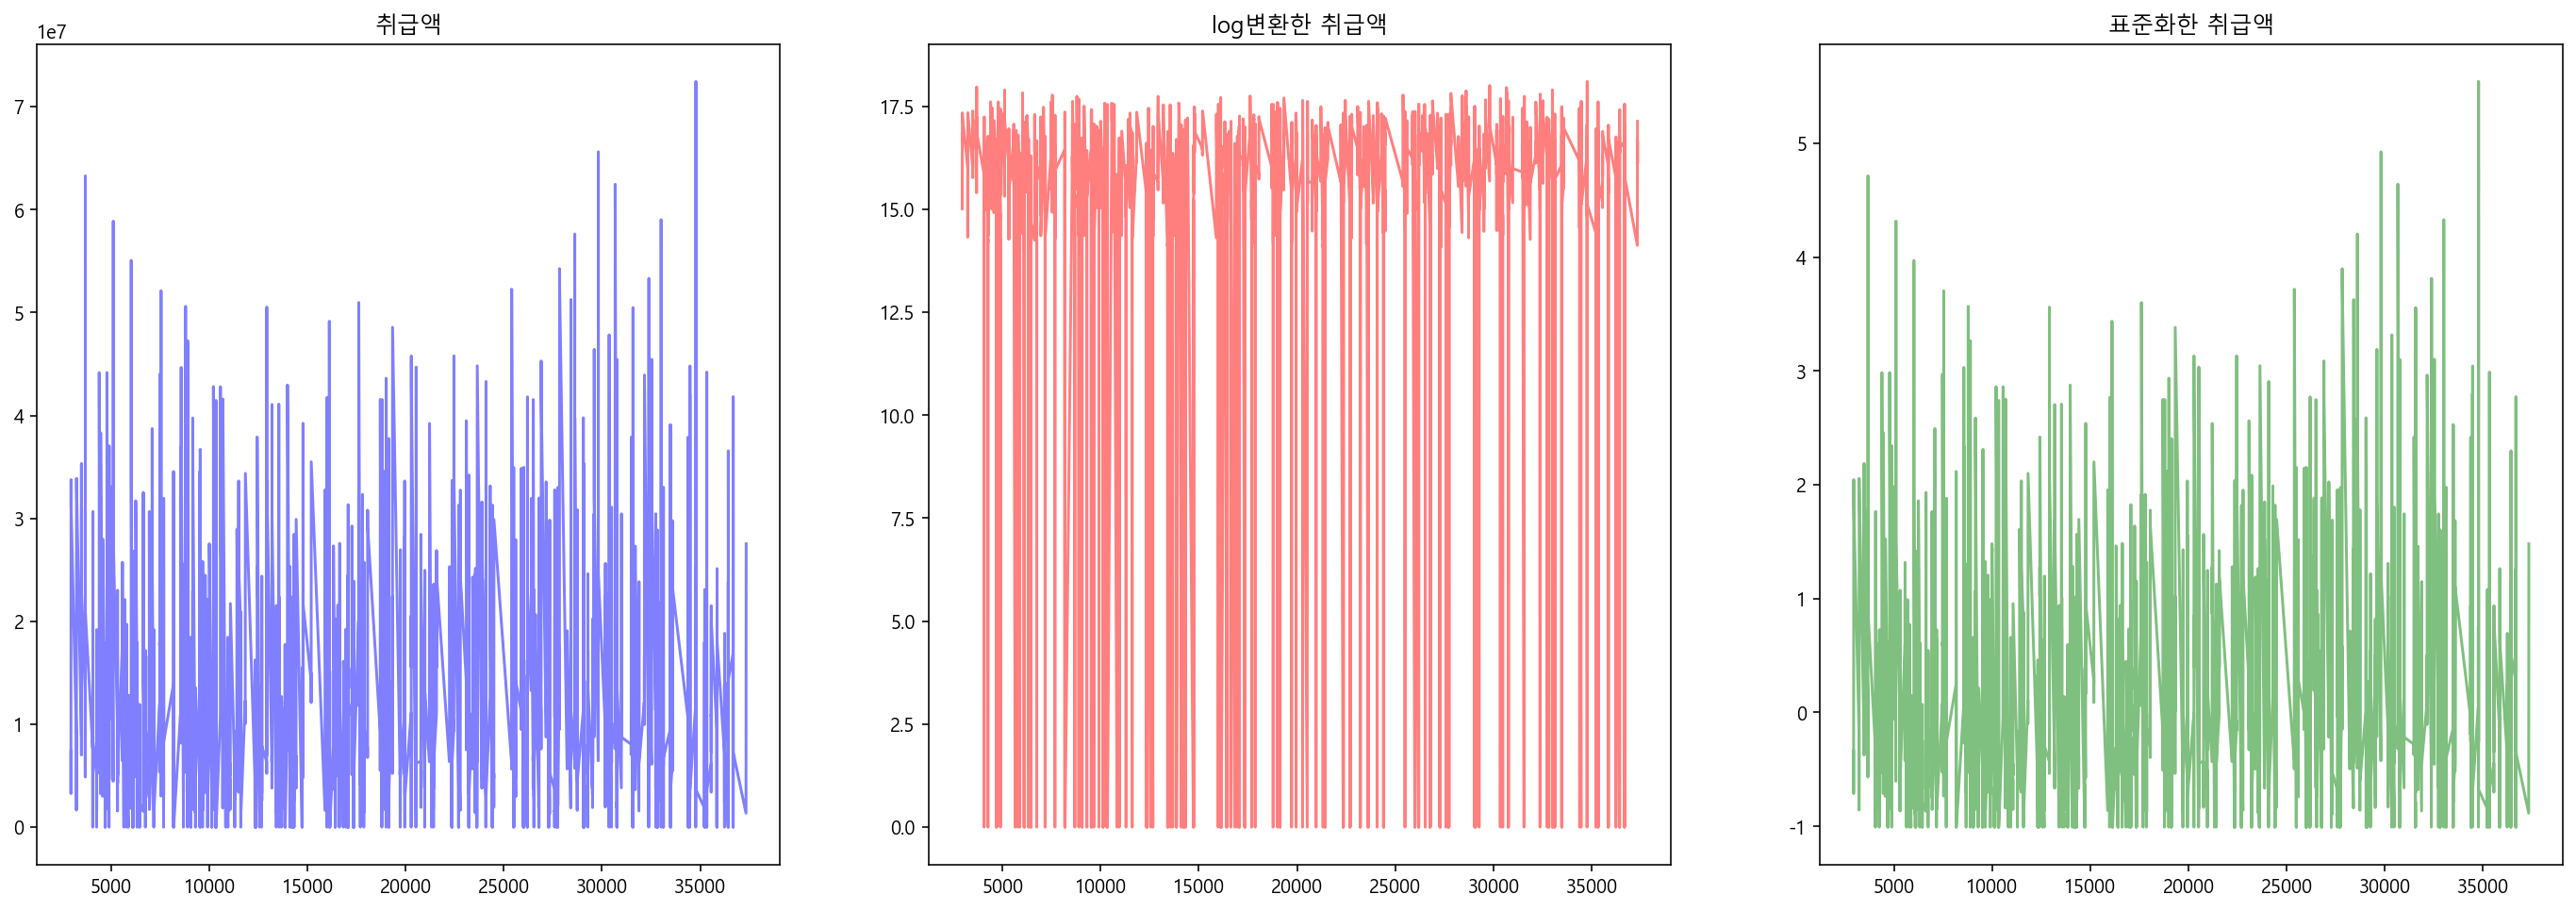


상품군: 가전
데이터 개수: 6479


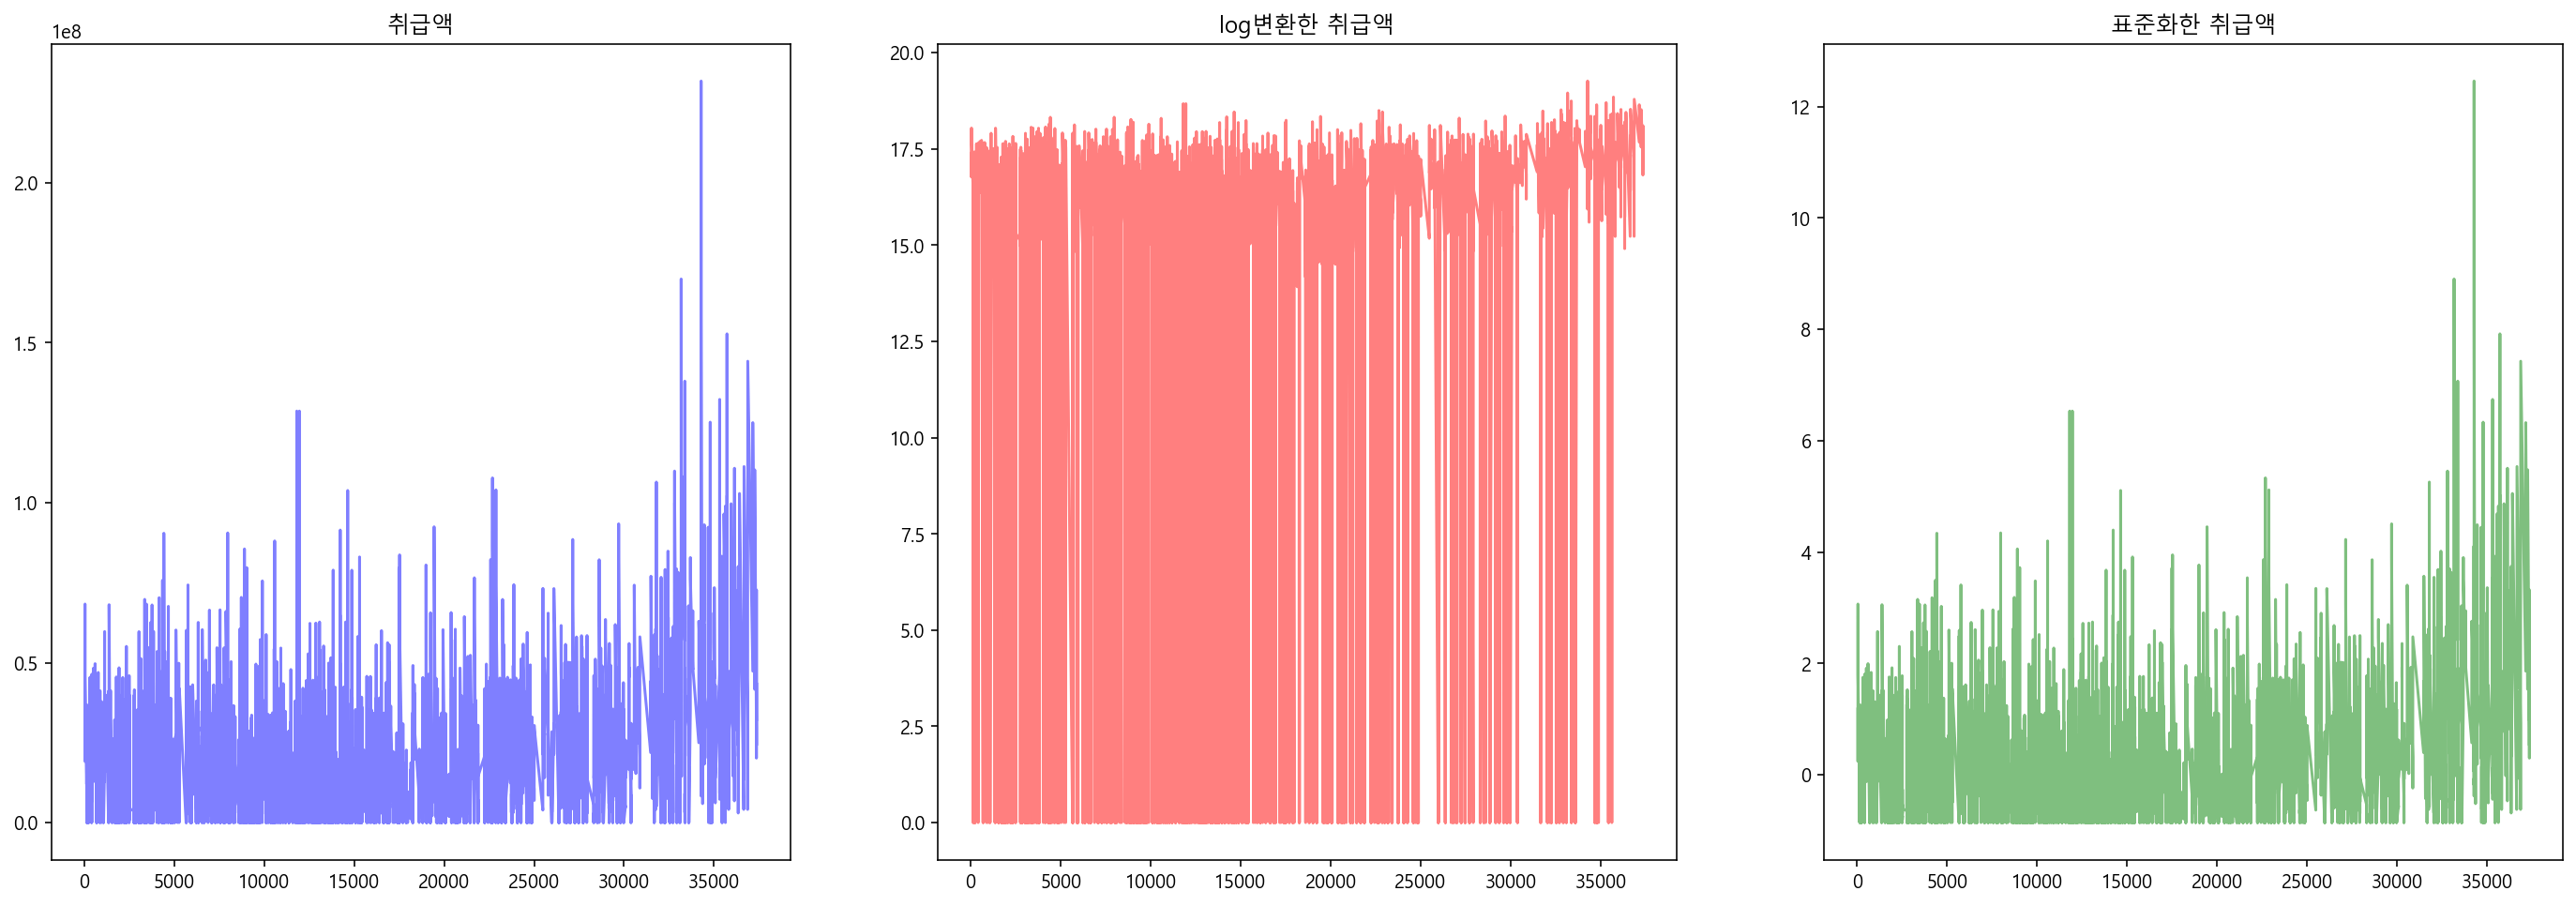


상품군: 건강기능
데이터 개수: 790


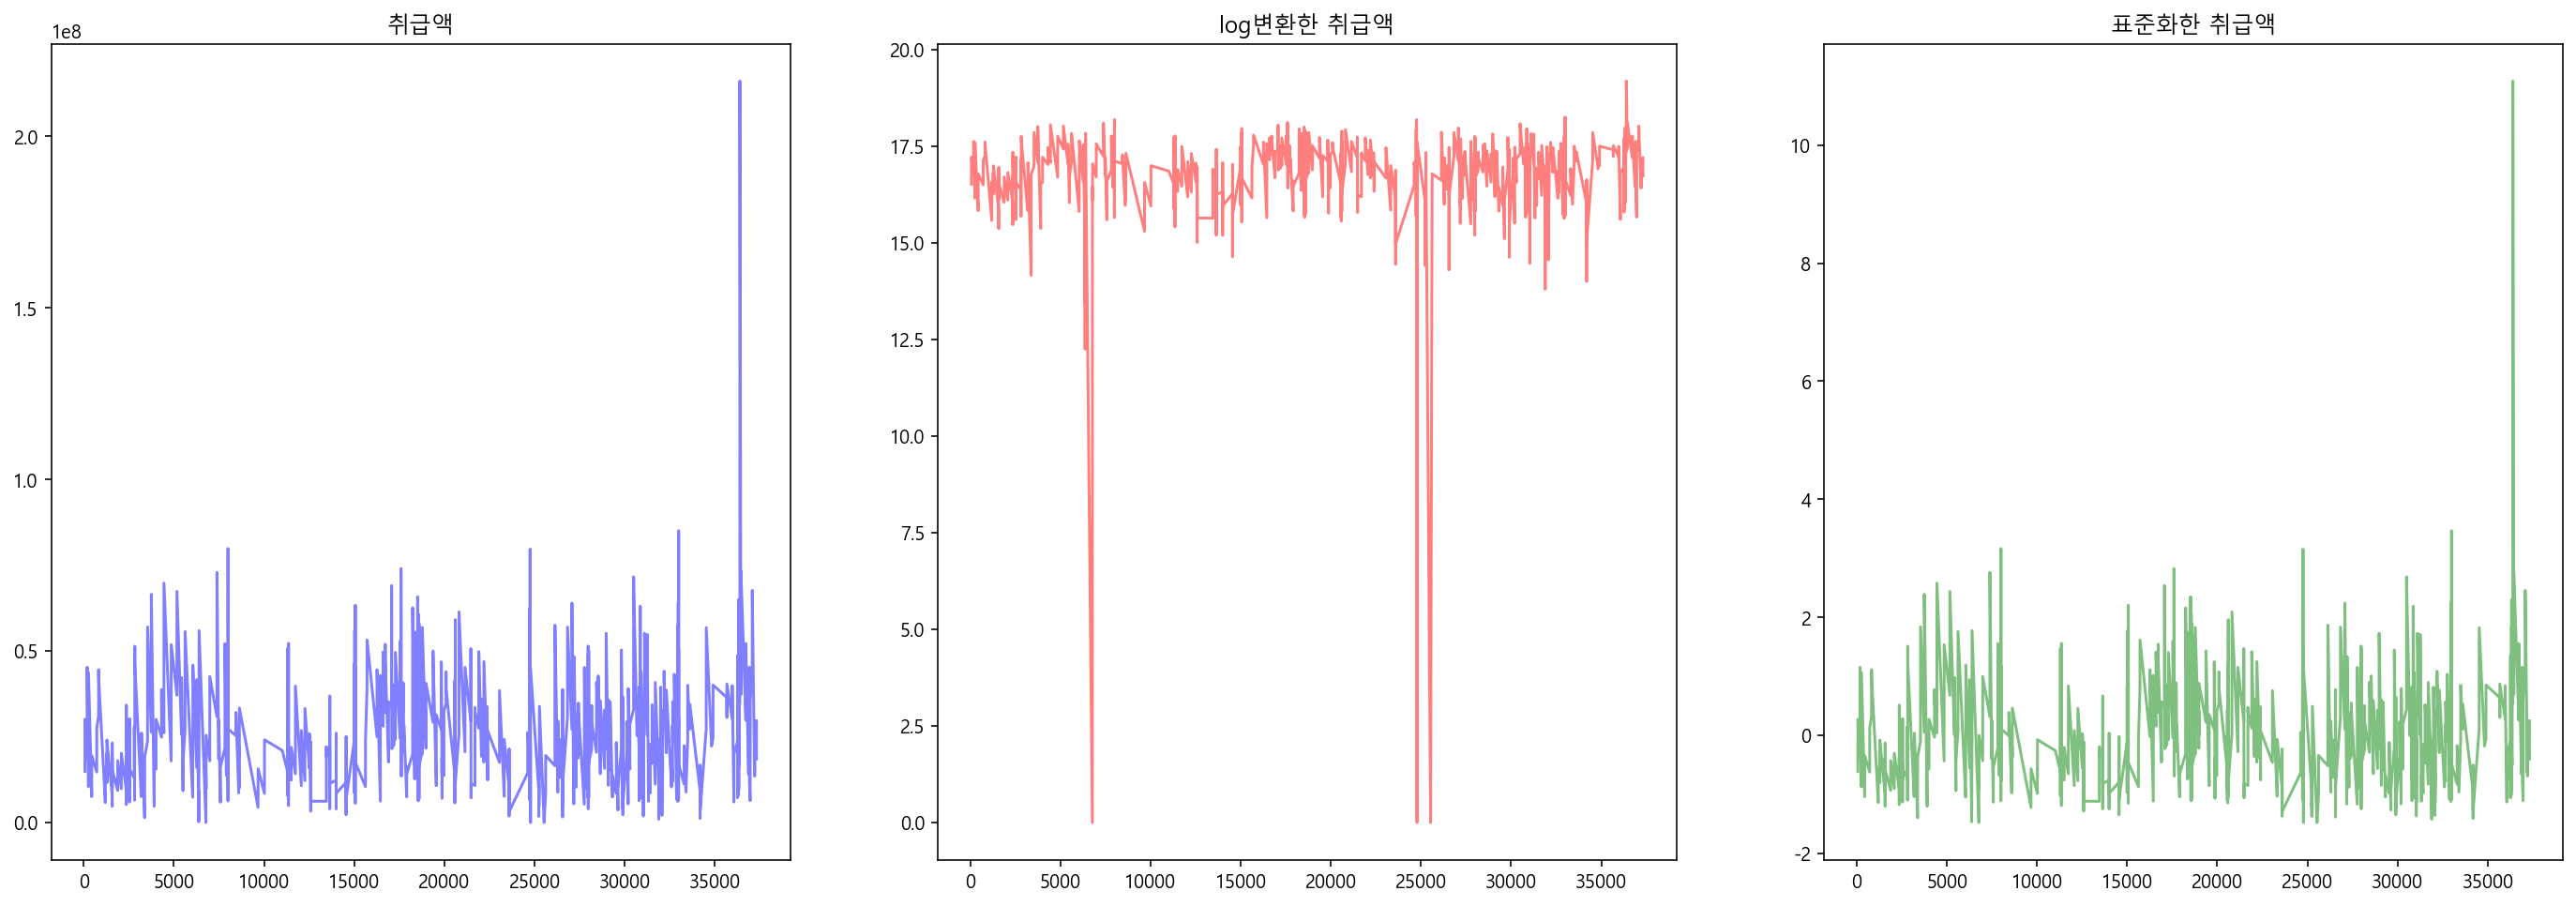


상품군: 농수축
데이터 개수: 3884


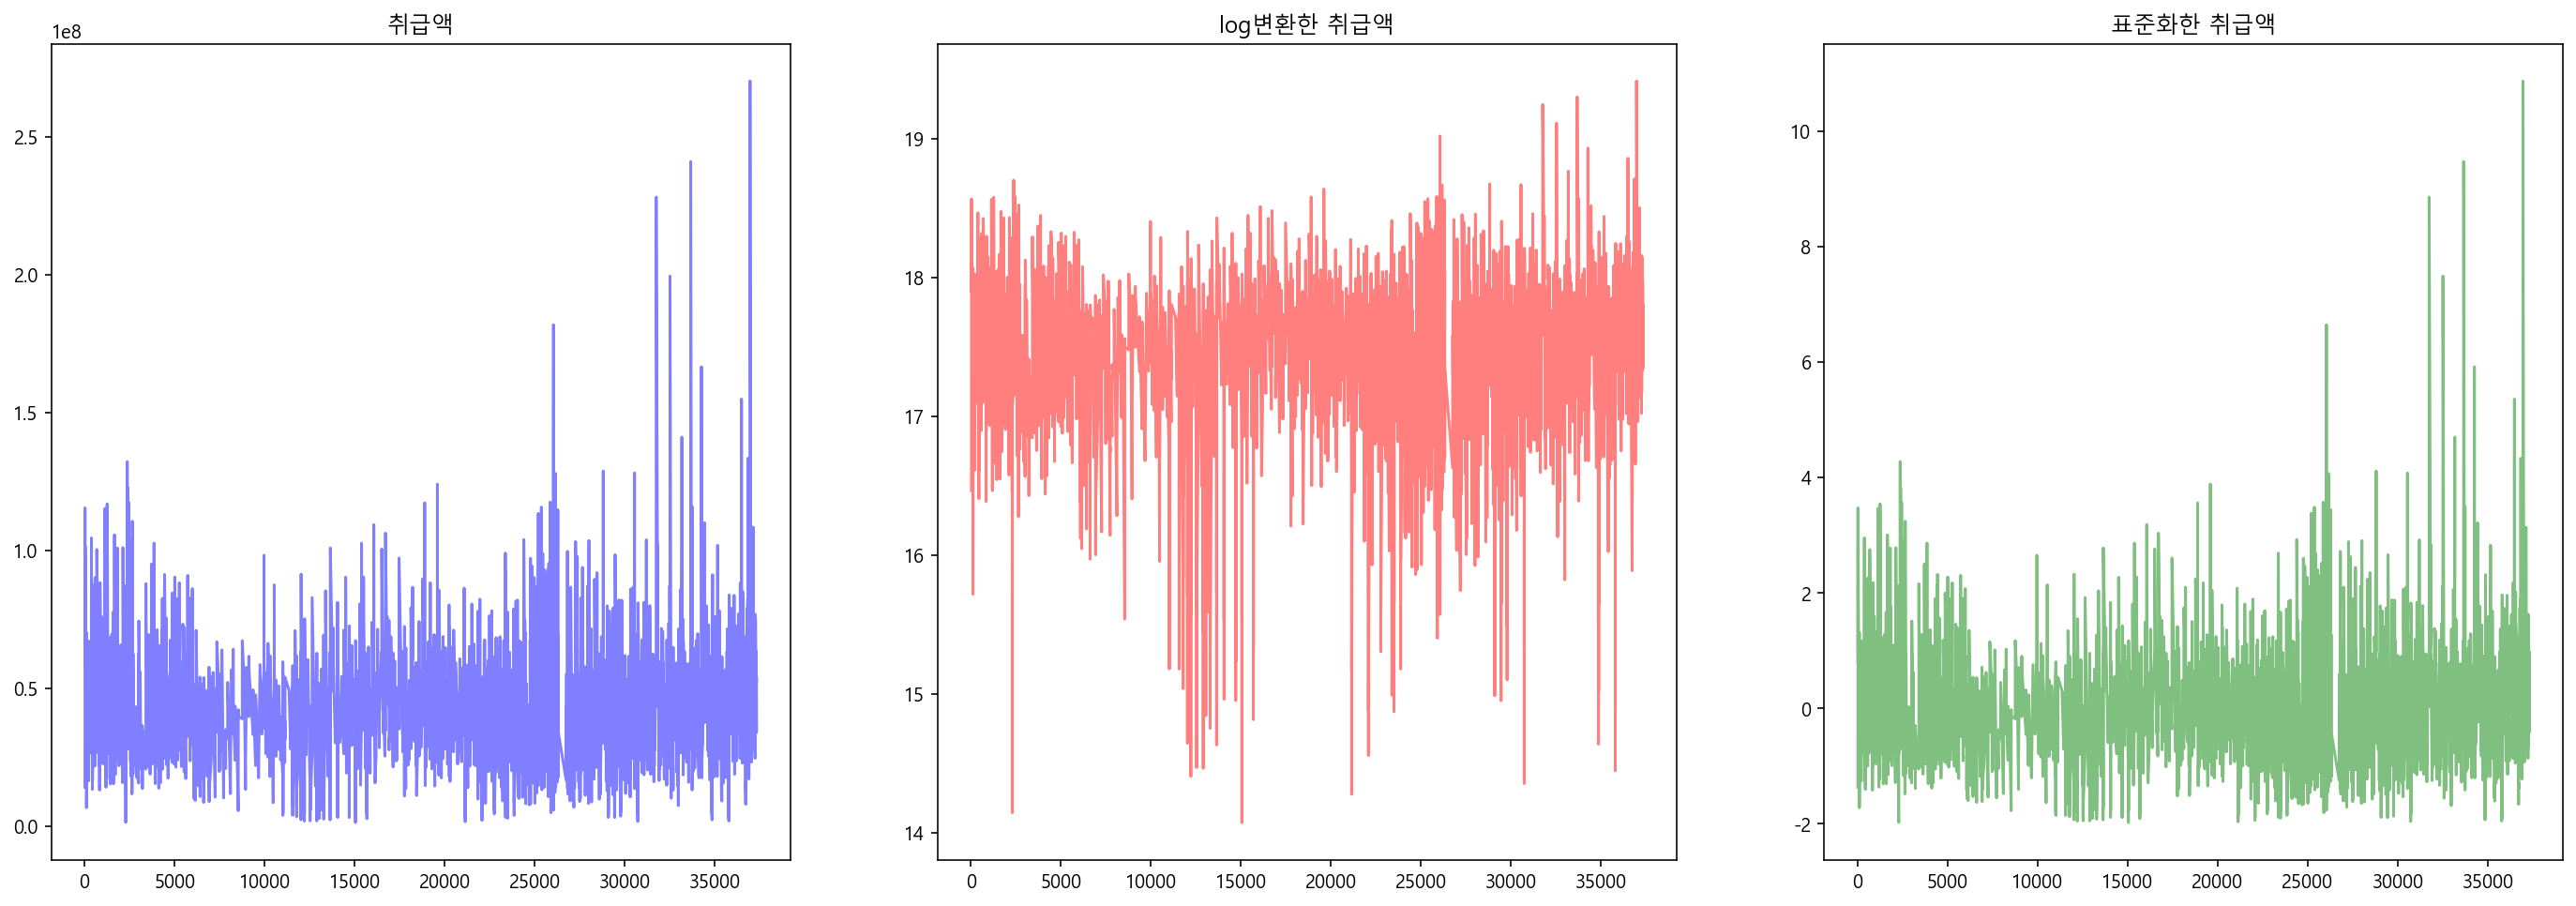


상품군: 생활용품
데이터 개수: 2877


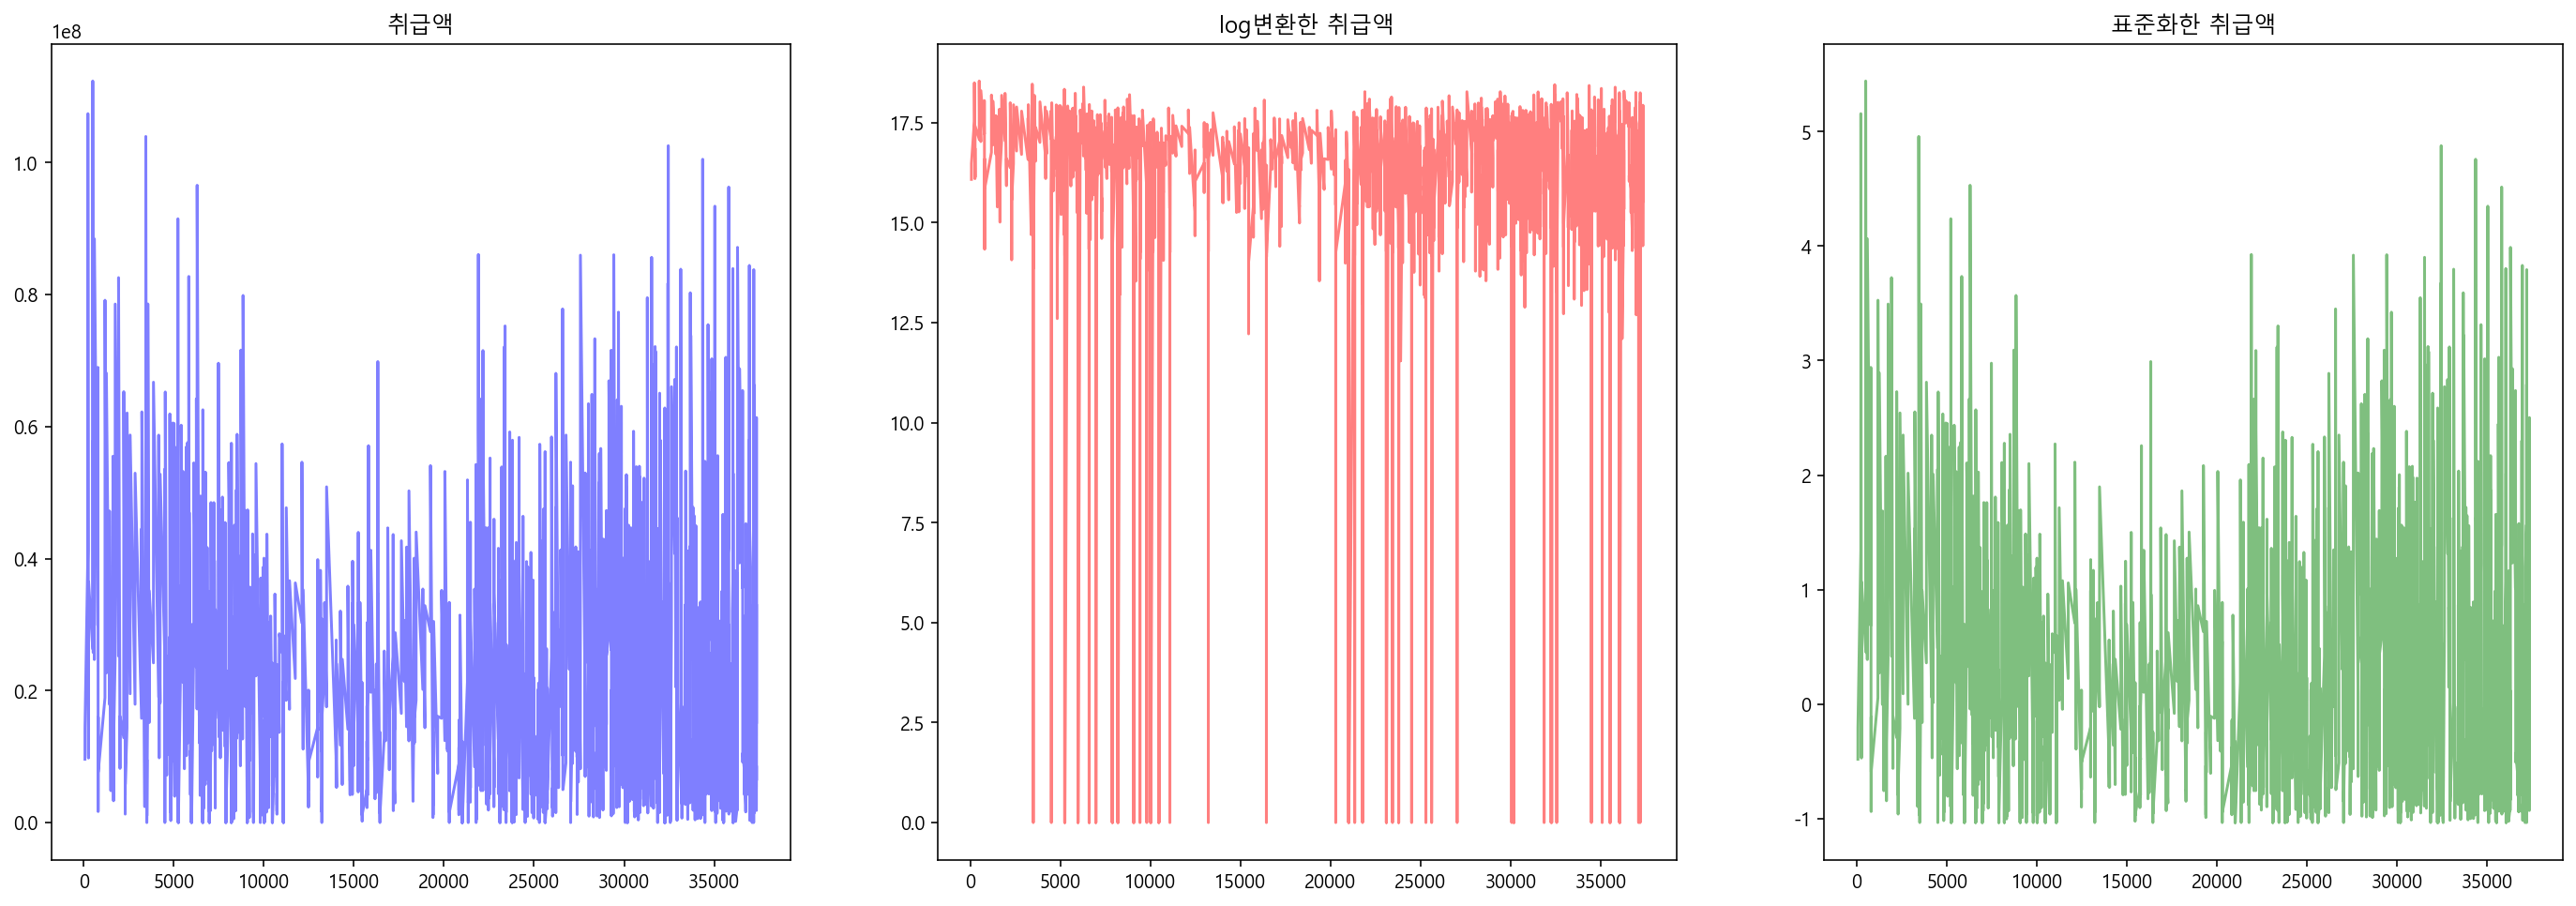


상품군: 속옷
데이터 개수: 3919


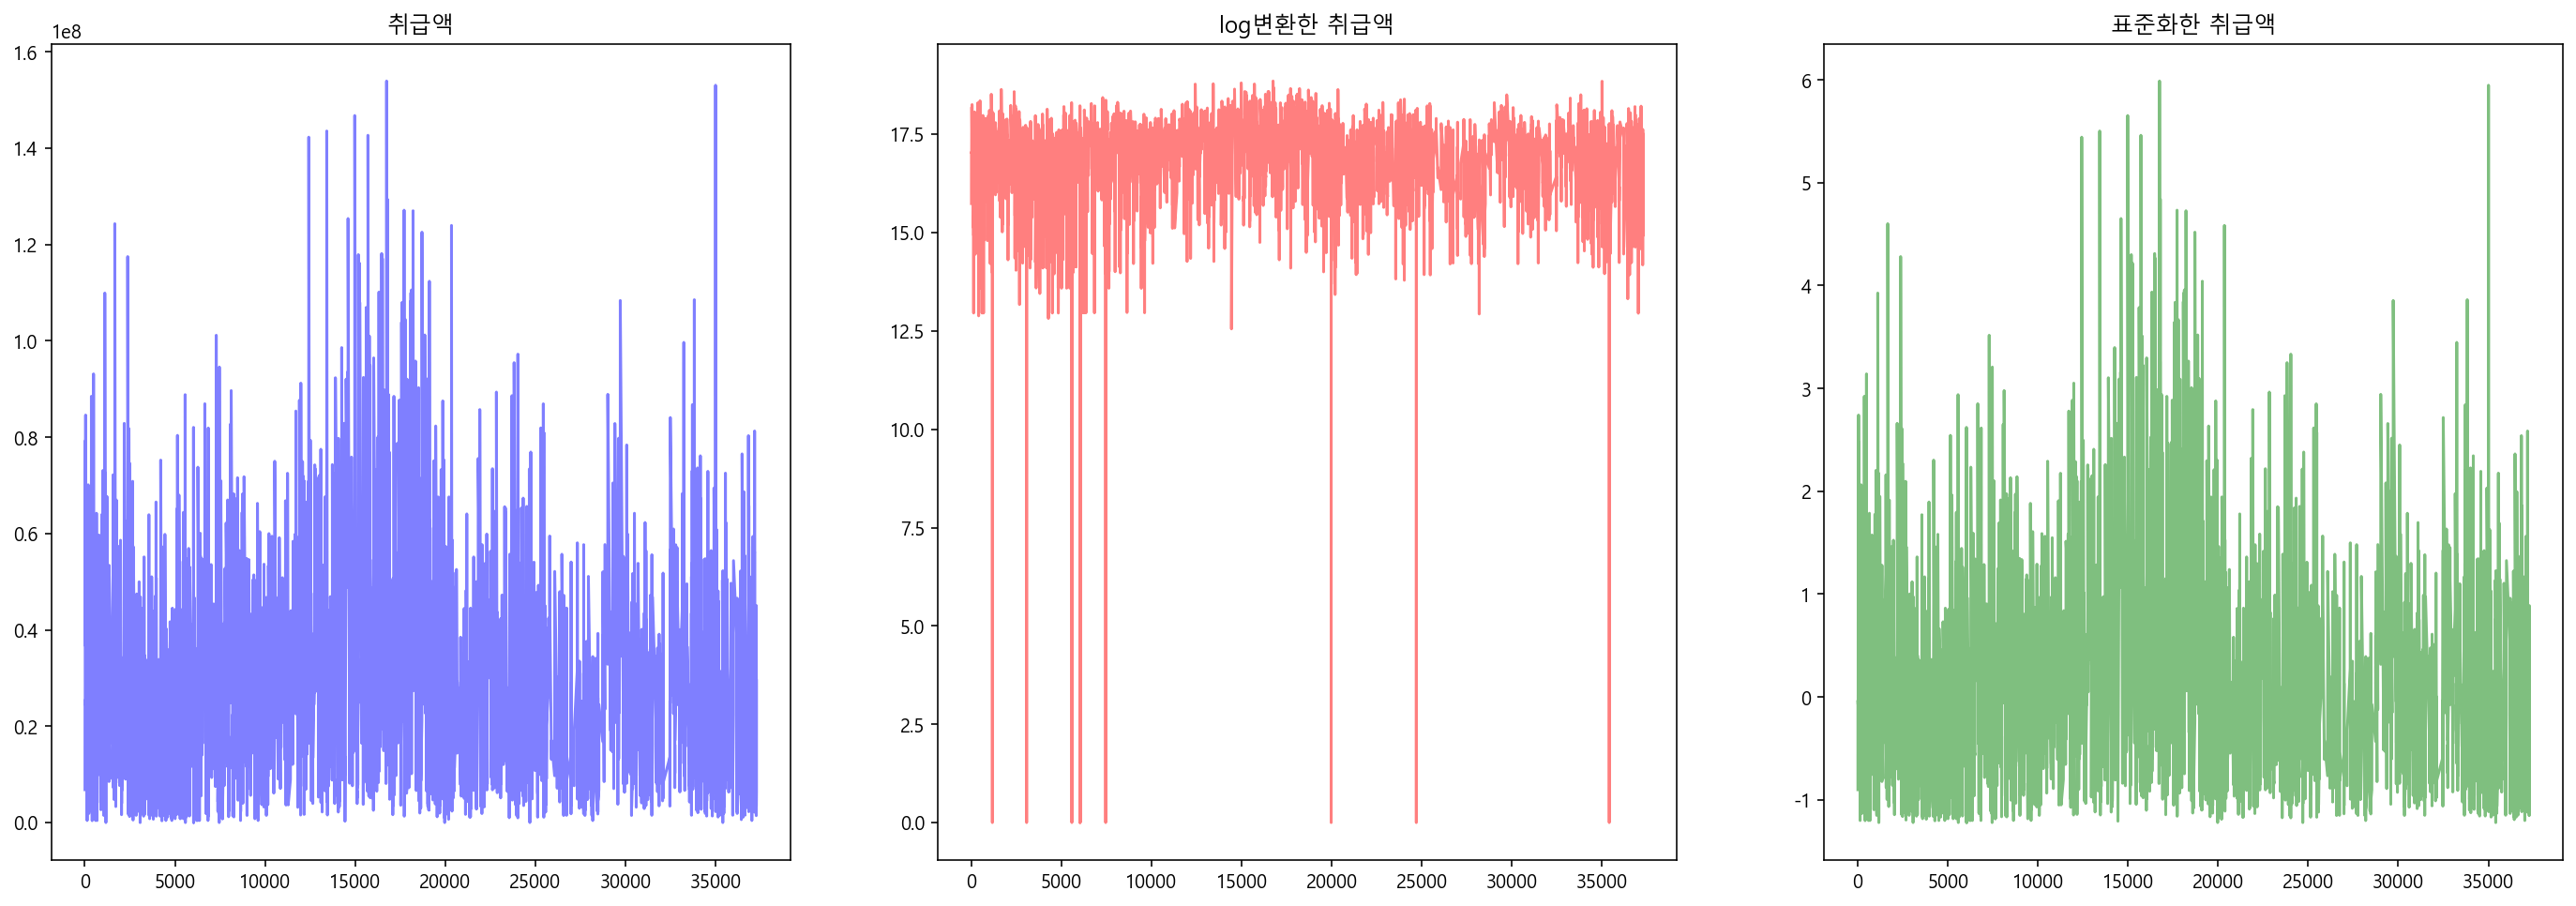


상품군: 의류
데이터 개수: 4340


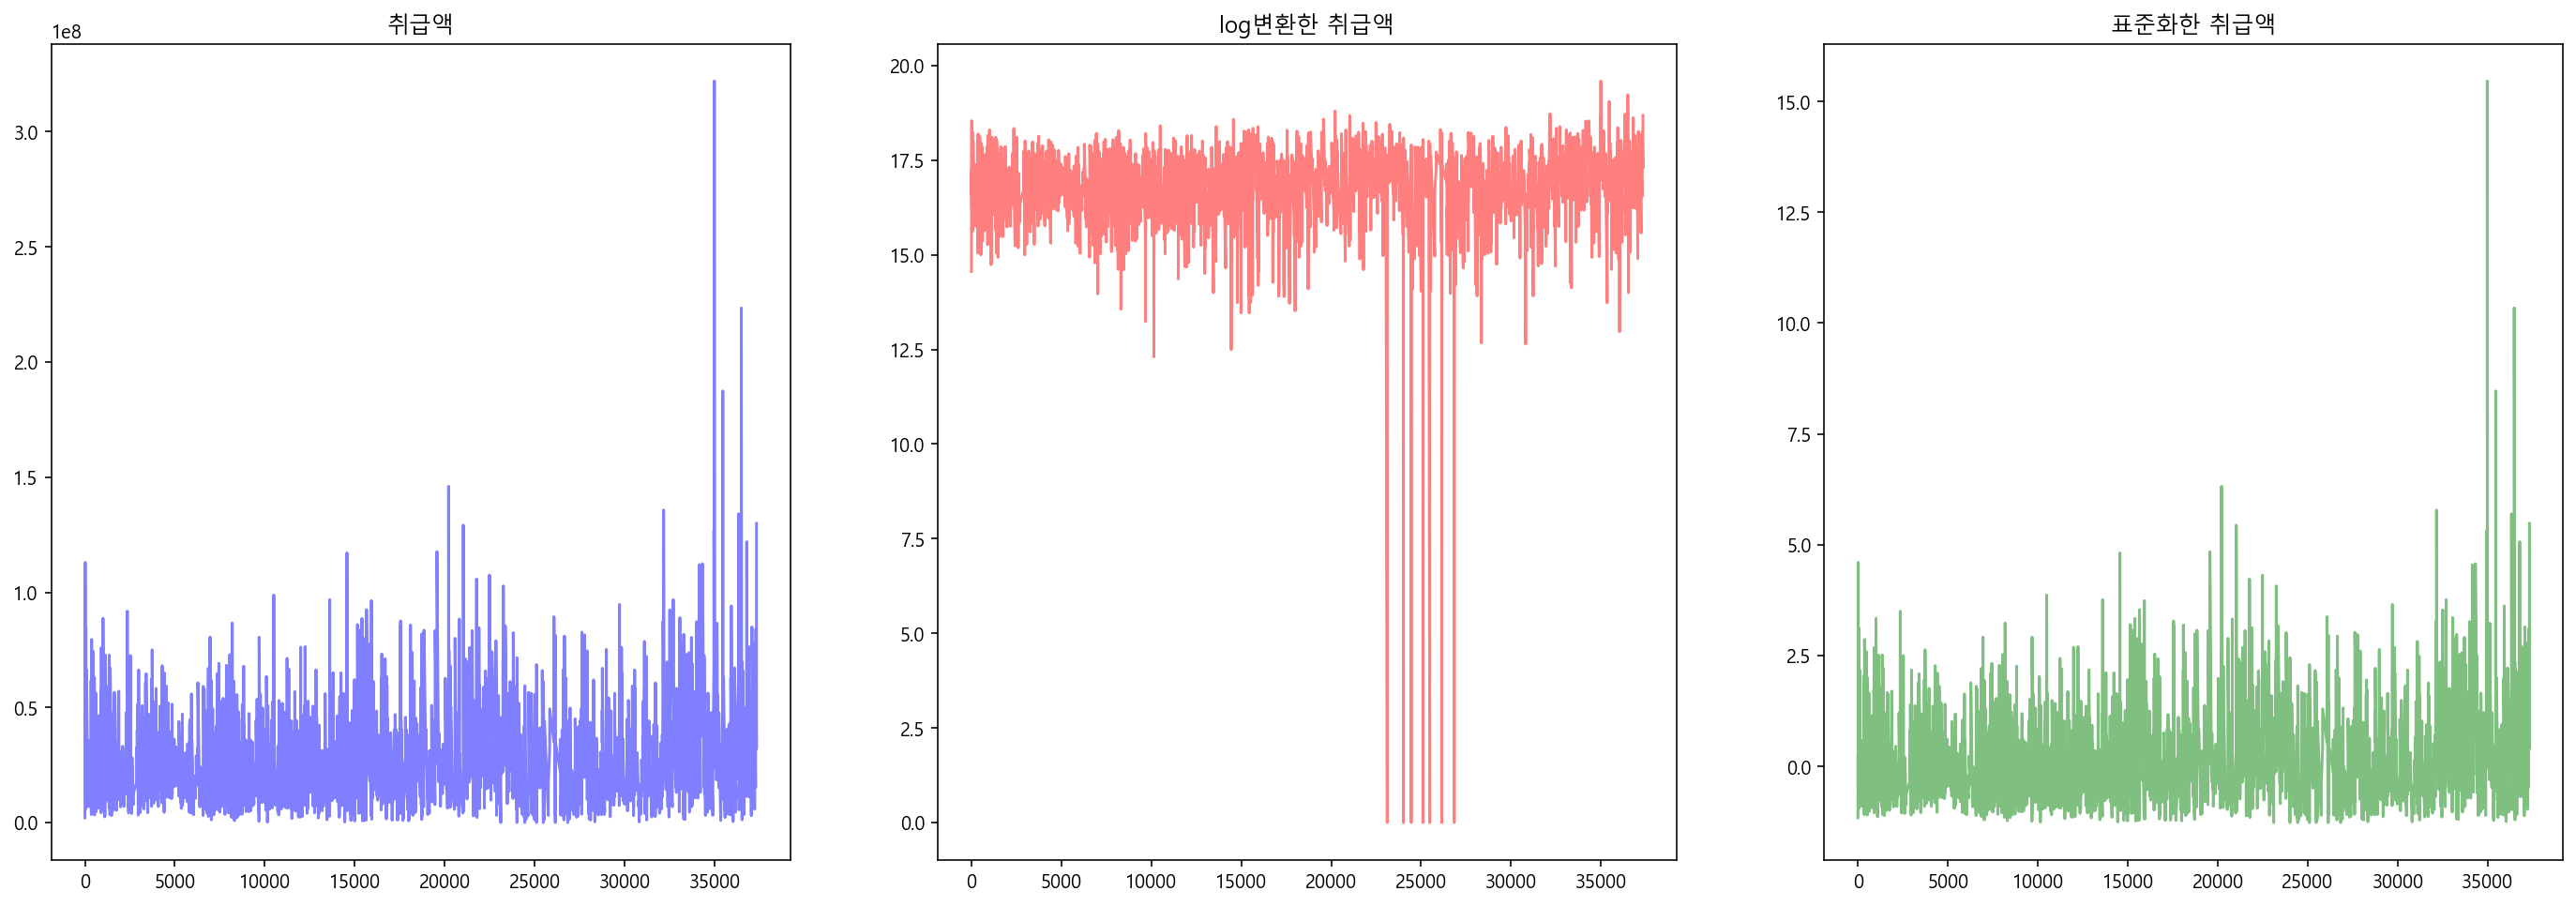


상품군: 이미용
데이터 개수: 1305


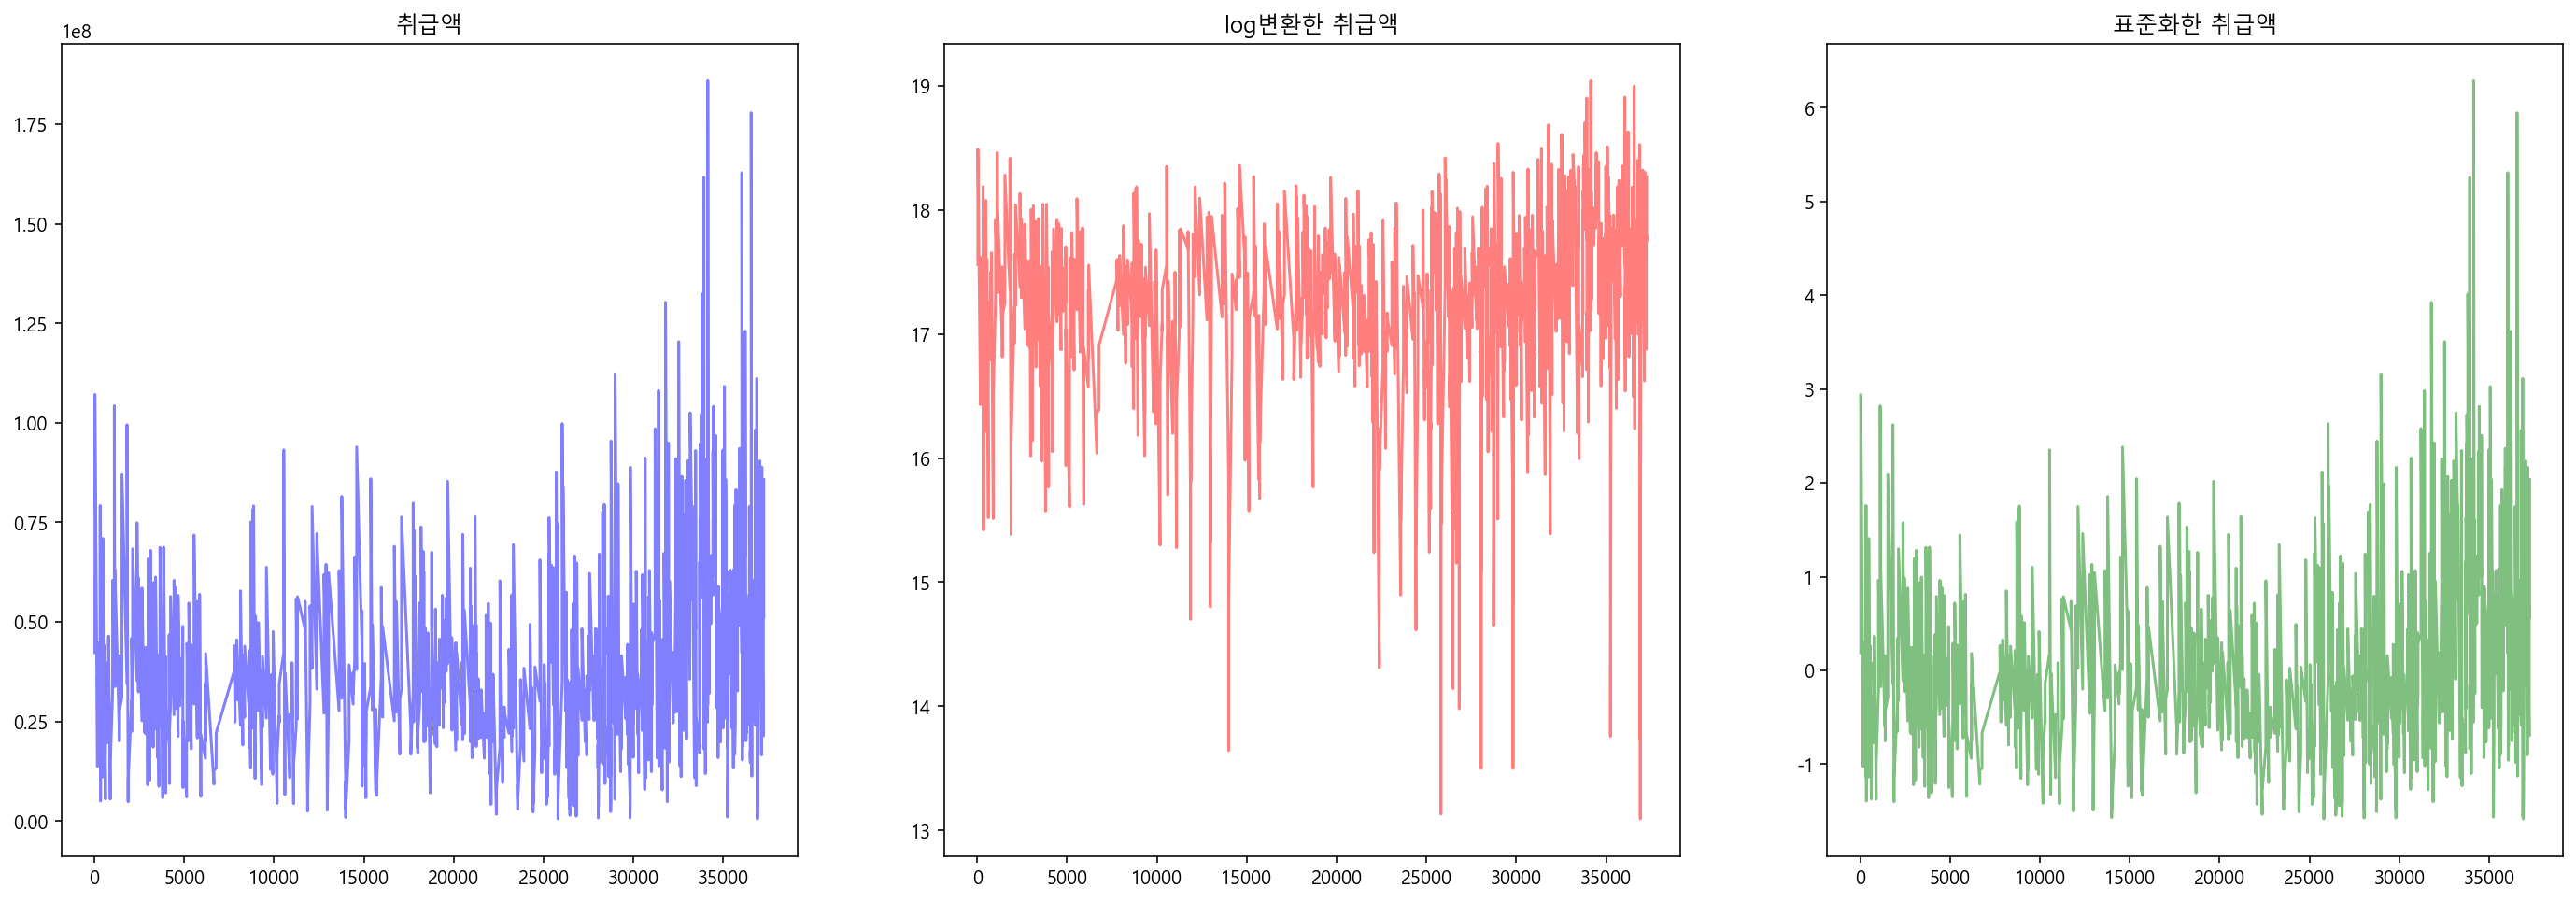


상품군: 잡화
데이터 개수: 3891


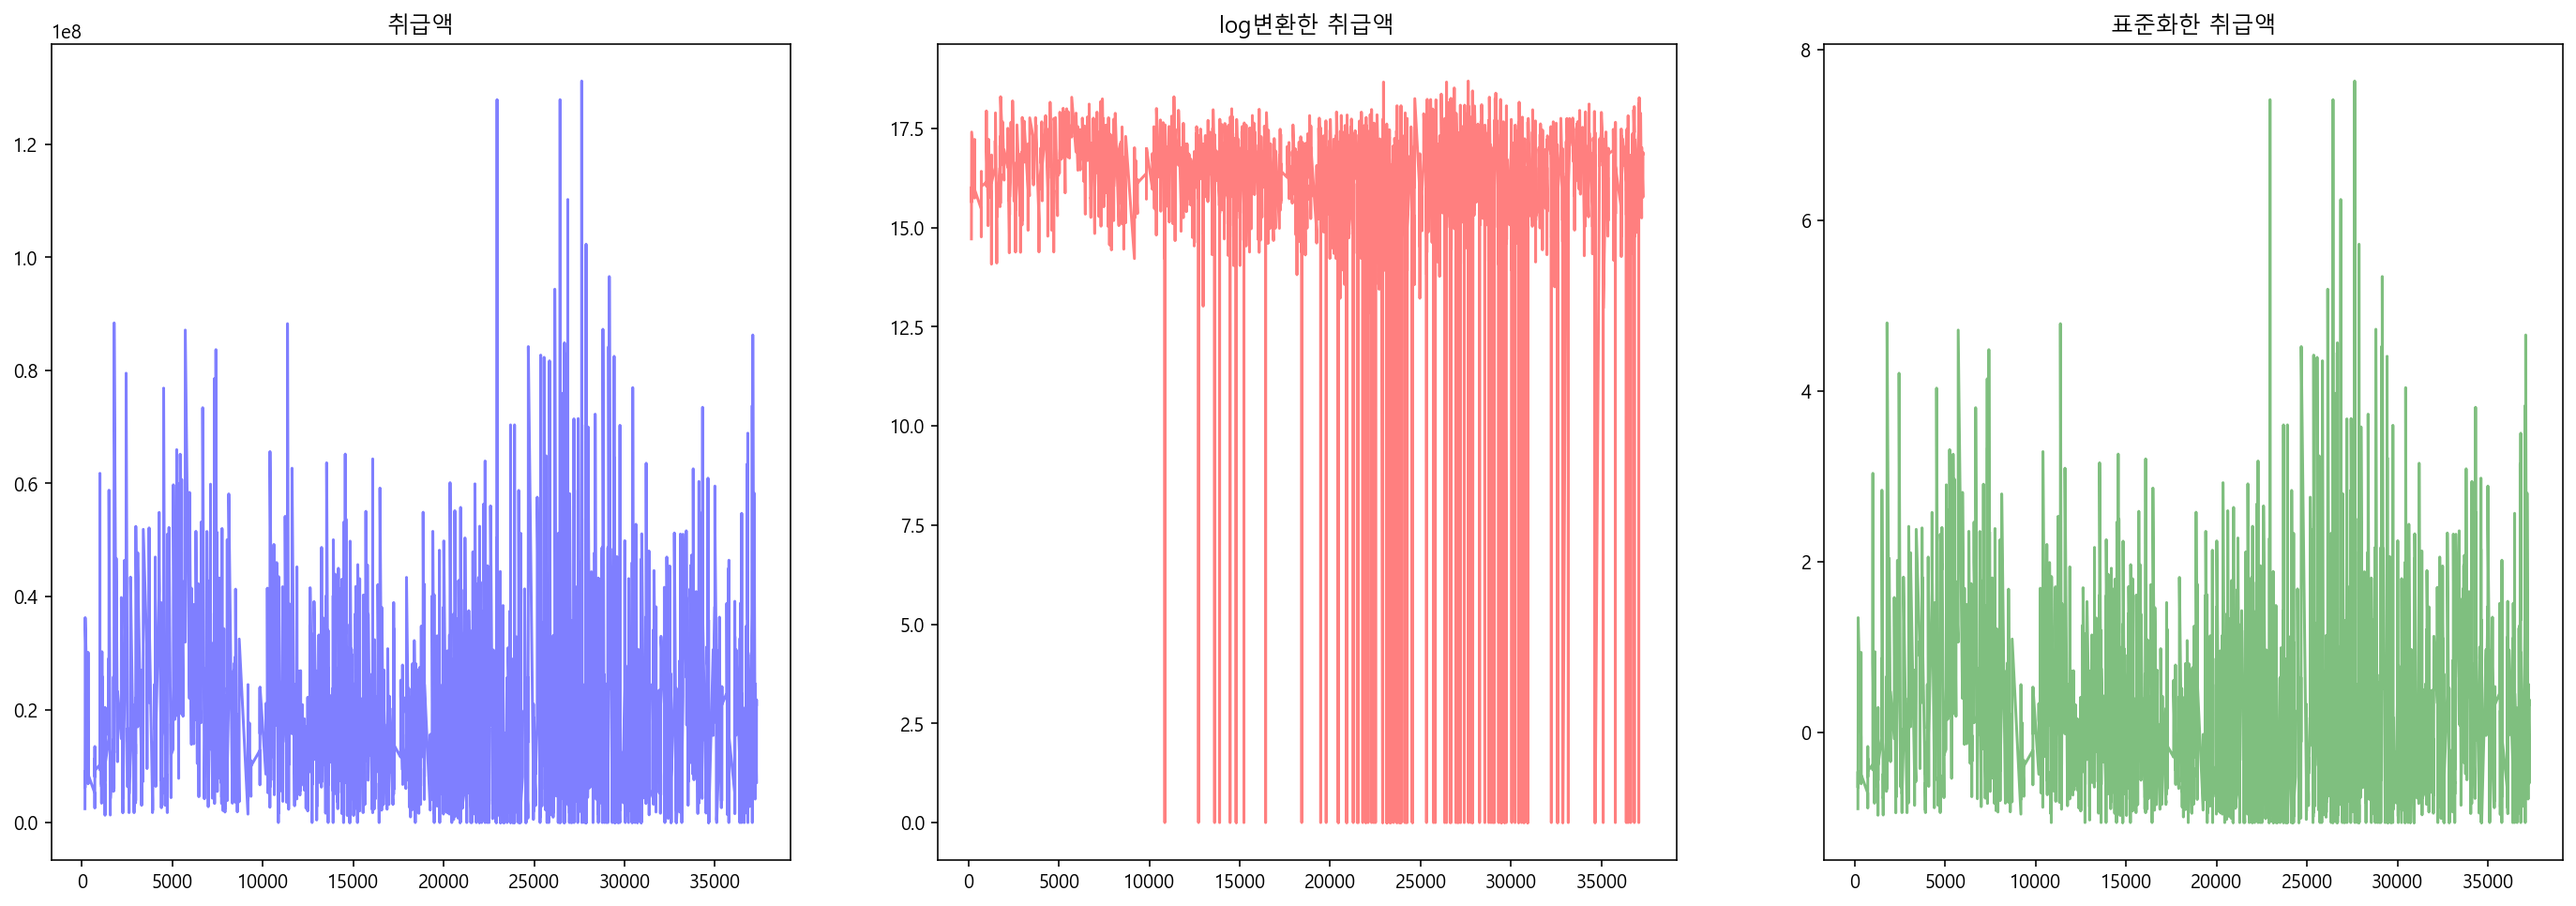


상품군: 주방
데이터 개수: 6604


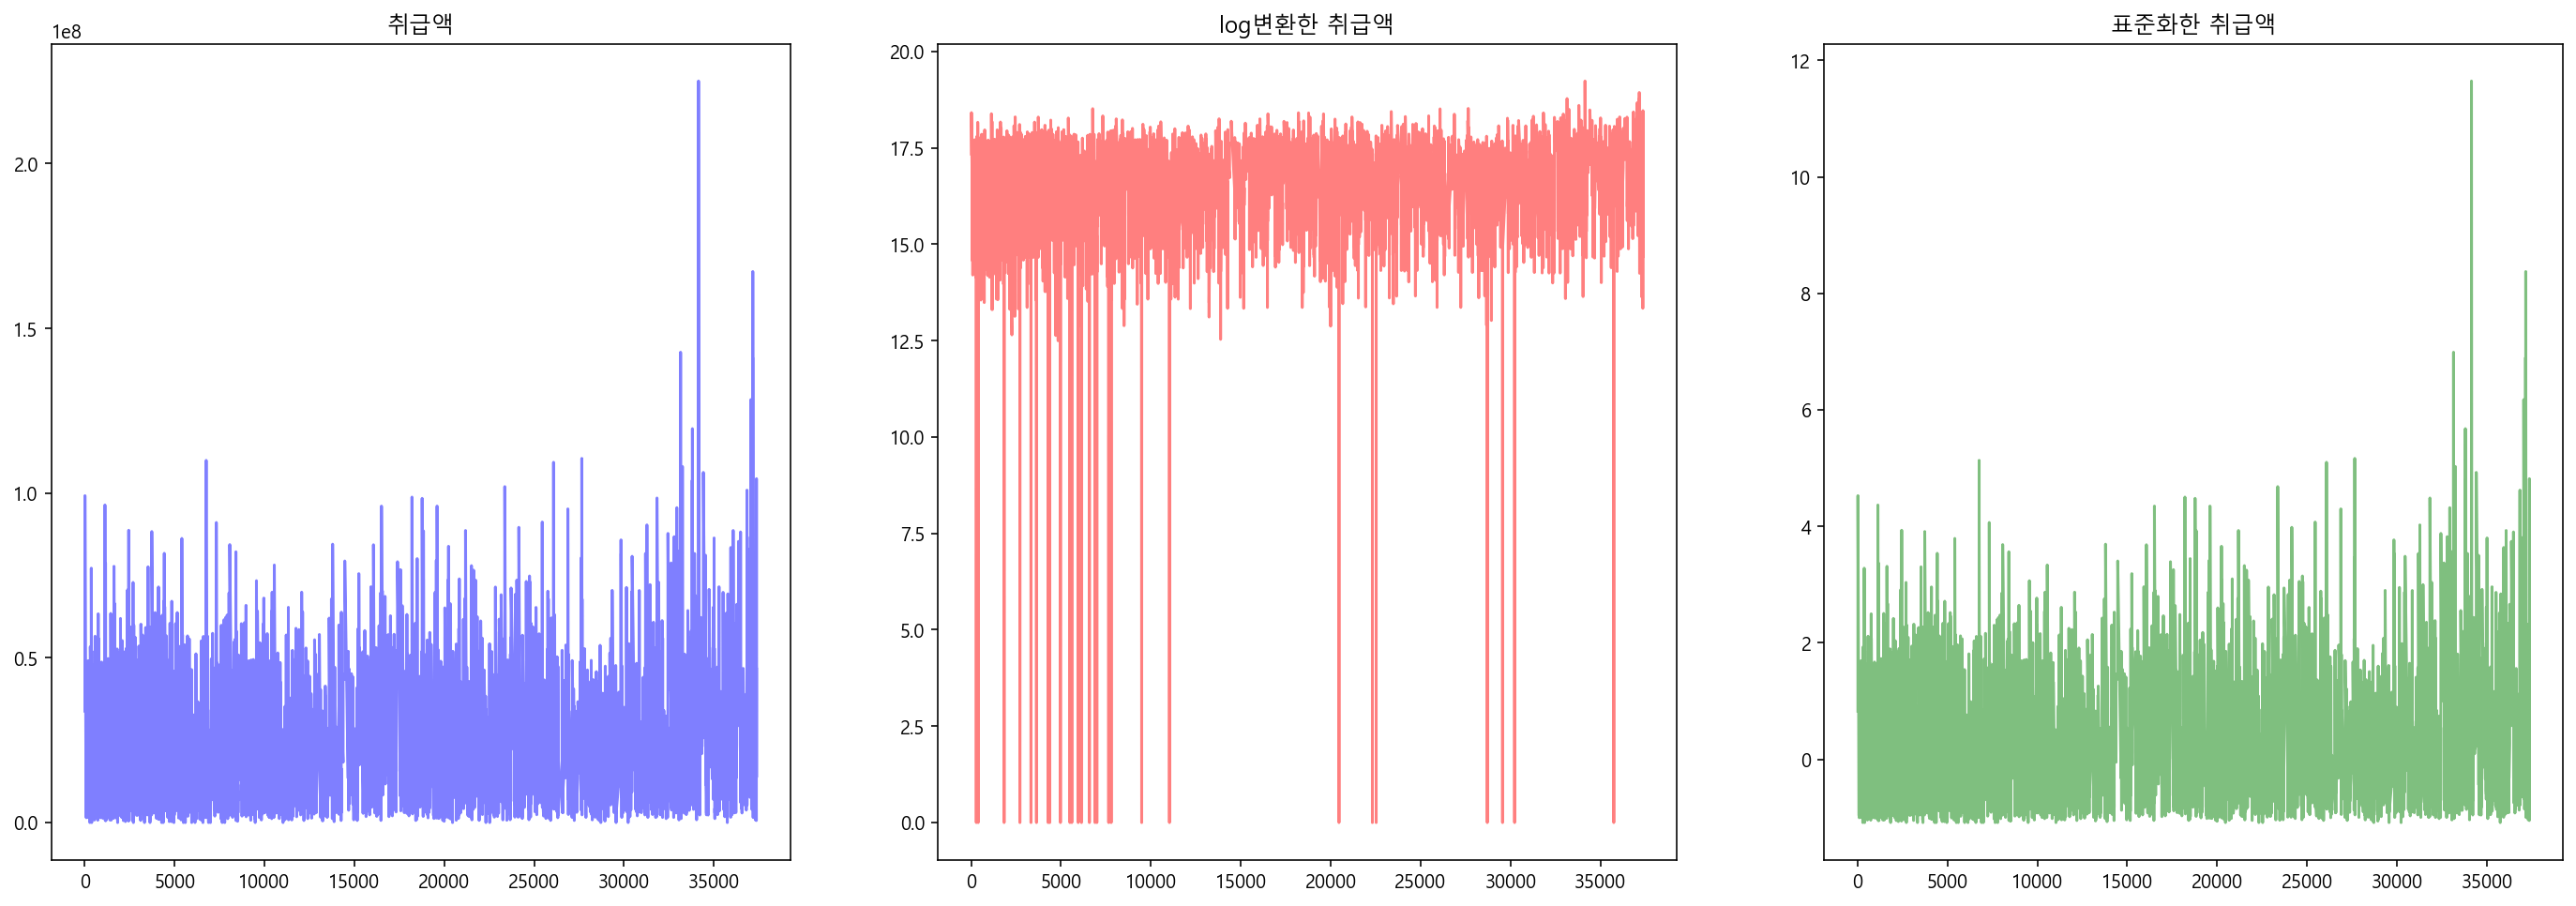


상품군: 침구
데이터 개수: 669


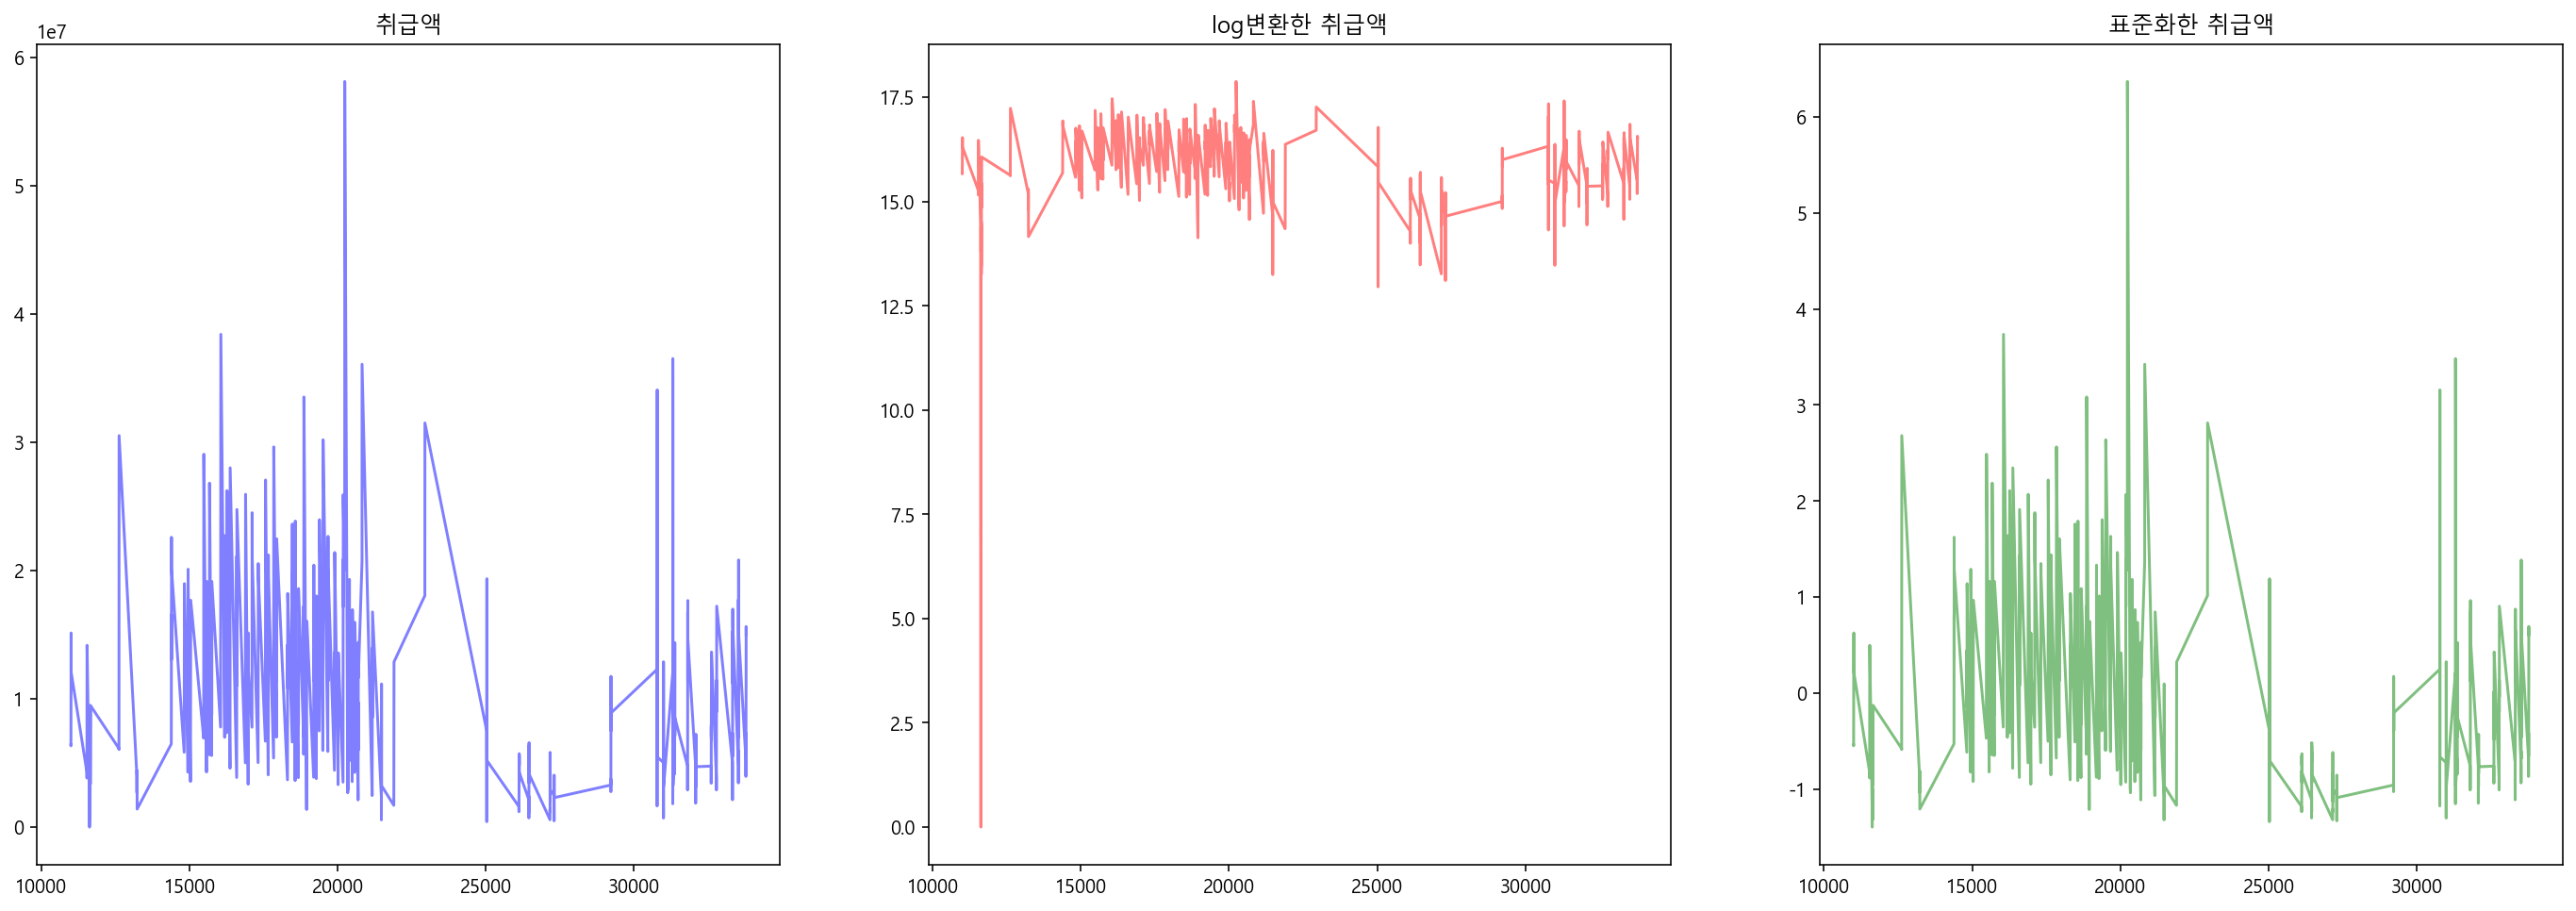

In [76]:
# 취급액 추이
dfs = dict(tuple(data.groupby(by='상품군')))
for k, v in dfs.items():
    
    scaler= StandardScaler()
    dfs[k]['취급액_표준화'] = scaler.fit_transform(dfs[k]['취급액'].values.reshape(-1, 1))
    
    fig = plt.figure(figsize=(24, 8))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    print(f"상품군: {k}\n데이터 개수: {len(dfs[k])}")  
    
    ax1.plot(dfs[k]['취급액'], color='blue', alpha=0.5)
    ax1.set_title('취급액')
    ax2.plot(np.log1p(dfs[k]['취급액']), color='red', alpha=0.5)
    ax2.set_title('log변환한 취급액')
    ax3.plot(dfs[k]['취급액_표준화'], color='green', alpha=0.5)
    ax3.set_title('표준화한 취급액')
    plt.show()
    print()

# 2. 상품군별 데이터(하루 단위)

In [79]:
# 데이터 로드
data = pd.read_excel(SALES_DATA, usecols=lambda x: 'Unnamed' not in x)
data

,마더코드,상품코드,상품군,상품명,방송시작,방송종료,노출(분),판매단가,취급액
0,100000,200000,이미용,엘로엘 아쿠아클린 마스크,2019-08-26 00:20:00,2019-08-26 01:20:00,60.0,79900,47611000
1,100000,200000,이미용,엘로엘 아쿠아클린 마스크,2019-08-30 01:00:00,2019-08-30 01:55:00,55.0,79900,28951000
2,100001,200001,주방,국내생산 스텐락 심플 스텐밀폐용기 17종,2019-01-25 16:00:00,2019-01-25 17:00:00,60.0,99000,87062000
3,100001,200001,주방,국내생산 스텐락 심플 스텐밀폐용기 17종,2019-02-01 13:00:00,2019-02-01 14:00:00,60.0,99000,64274000
4,100002,200002,농수축,이보은의 우삽겹 12팩세트,2019-10-29 17:00:00,2019-10-29 18:00:00,60.0,49900,128483000
...,...,...,...,...,...,...,...,...,...
13274,100849,202513,농수축,멋진밥상 흥양농협 햅쌀 20kg,2019-11-14 16:20:00,2019-11-14 17:20:00,60.0,58900,129387000
13275,100849,202513,농수축,멋진밥상 흥양농협 햅쌀 20kg,2019-12-05 15:00:00,2019-12-05 15:20:00,20.0,58900,52542000
13276,100849,202513,농수축,멋진밥상 흥양농협 햅쌀 20kg,2019-12-11 15:00:00,2019-12-11 15:20:00,20.0,58900,45331000
13277,100849,202513,농수축,멋진밥상 흥양농협 햅쌀 20kg,2019-12-14 17:40:00,2019-12-14 18:00:00,20.0,58900,51303000


상품군: 가구
데이터 개수: 885


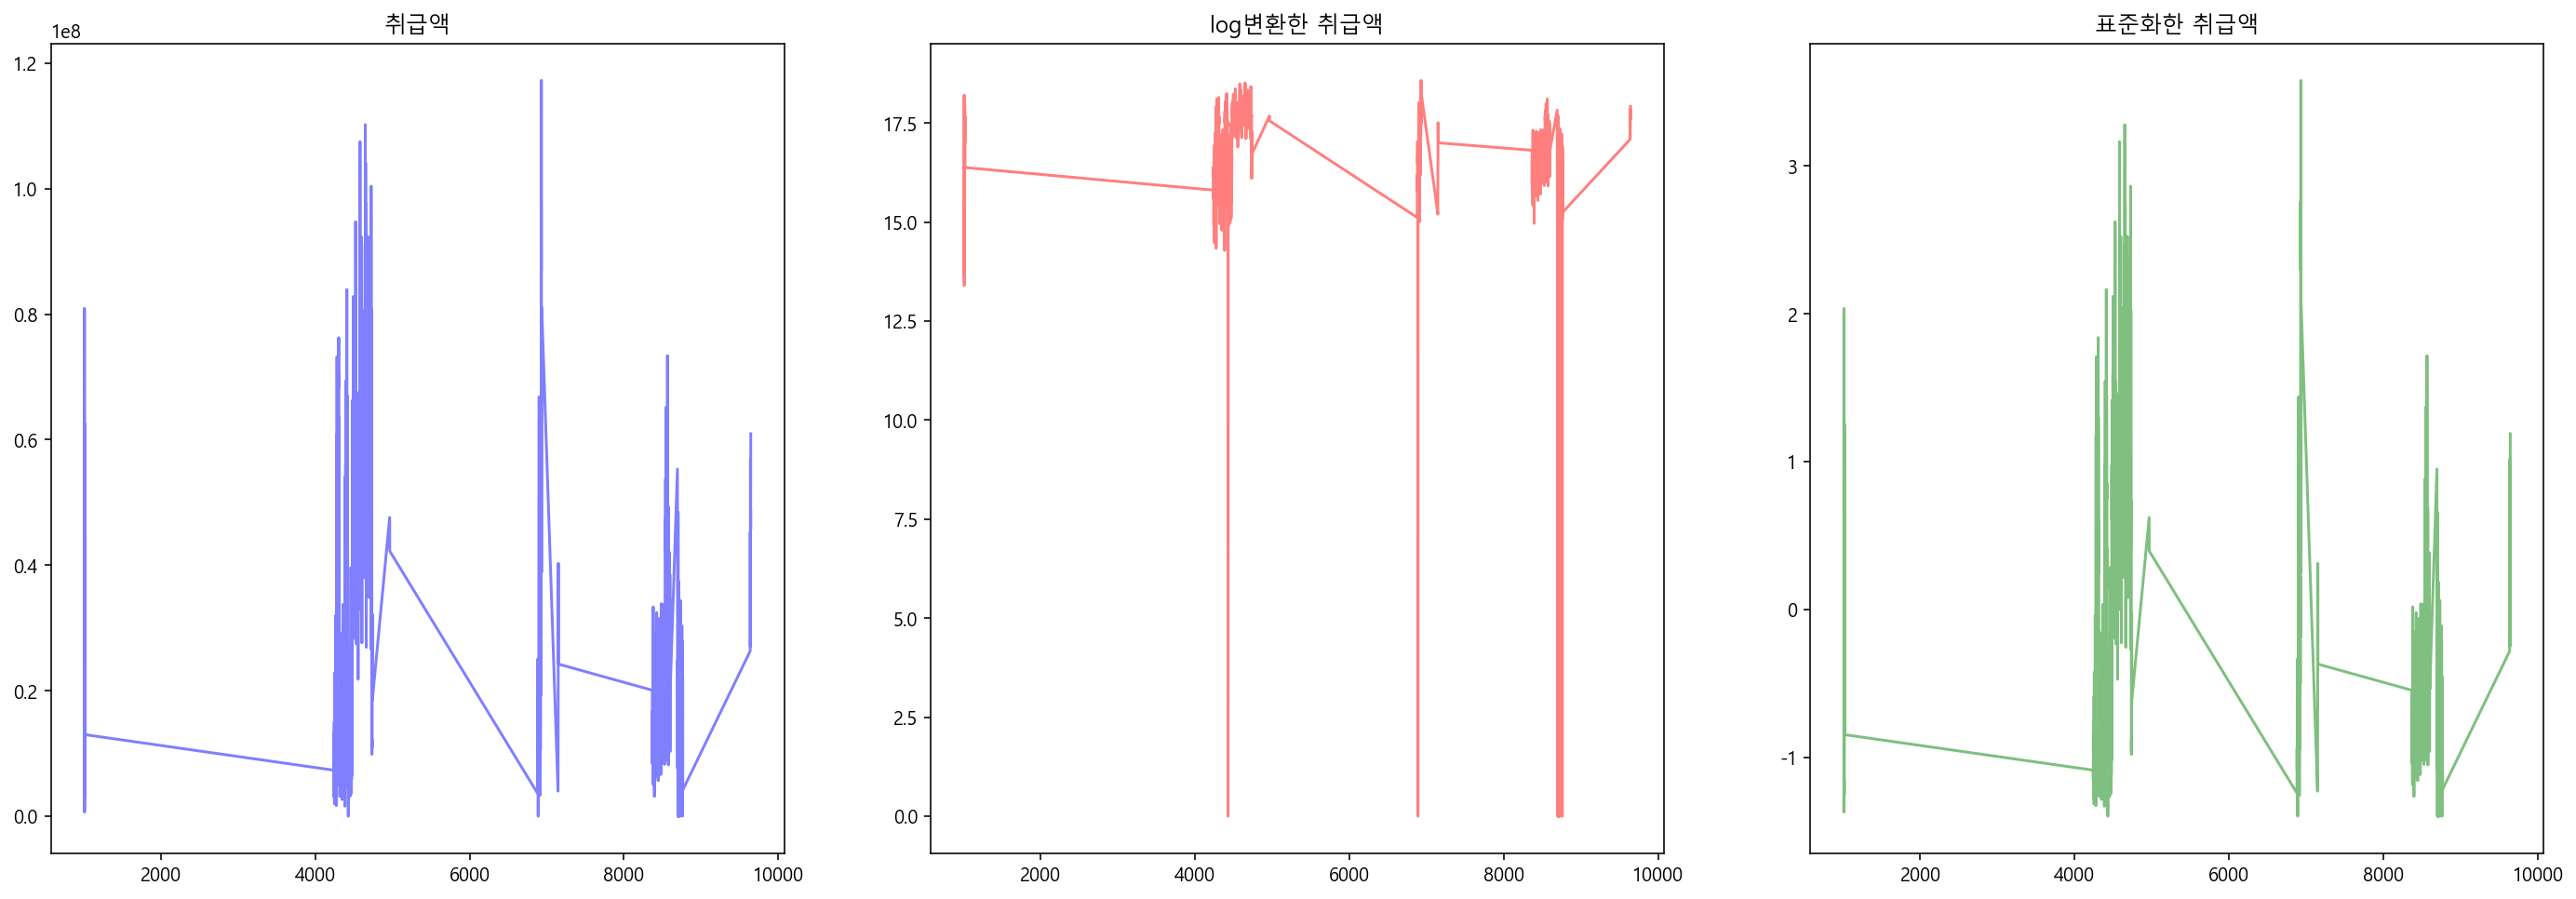


상품군: 가전
데이터 개수: 2179


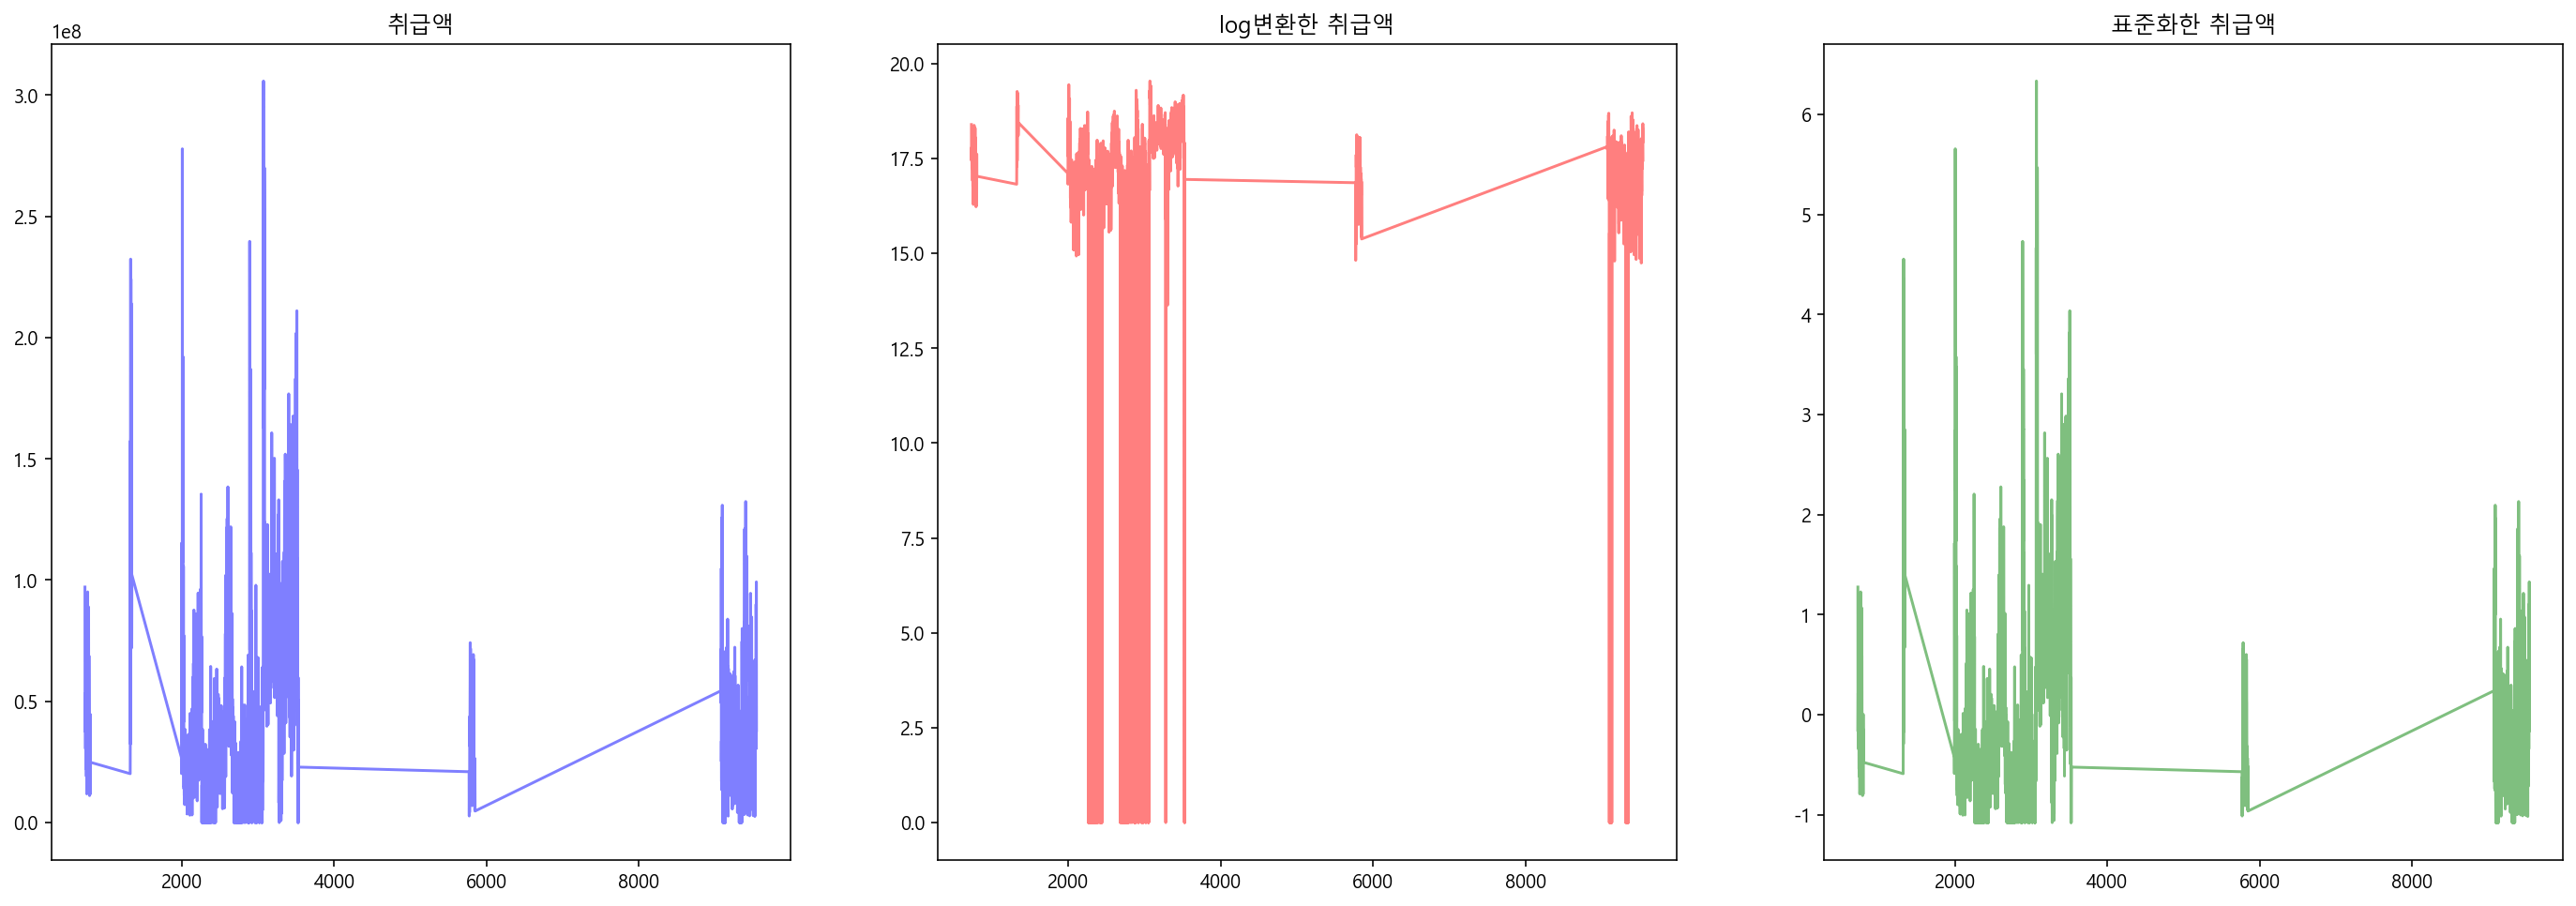


상품군: 건강기능
데이터 개수: 271


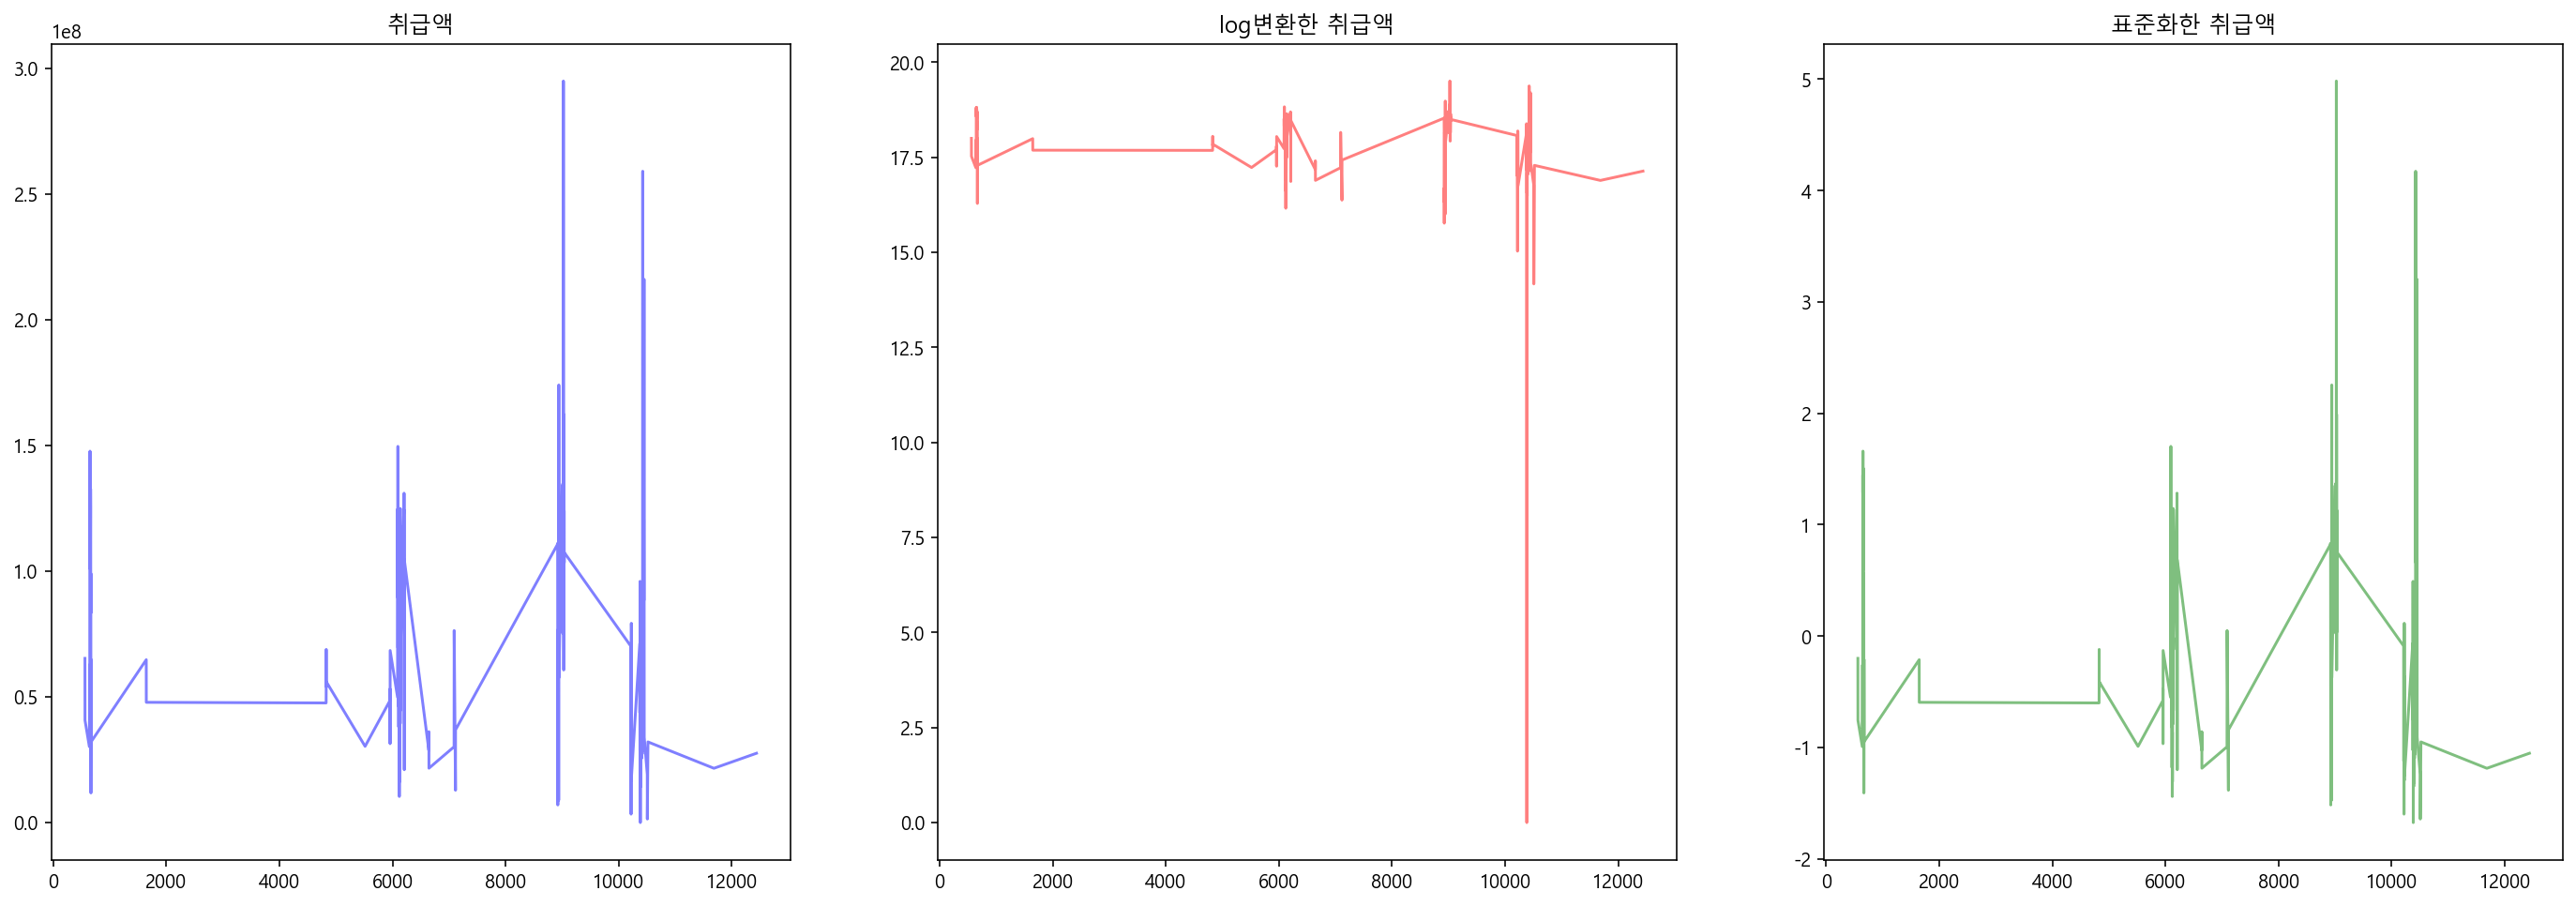


상품군: 농수축
데이터 개수: 1317


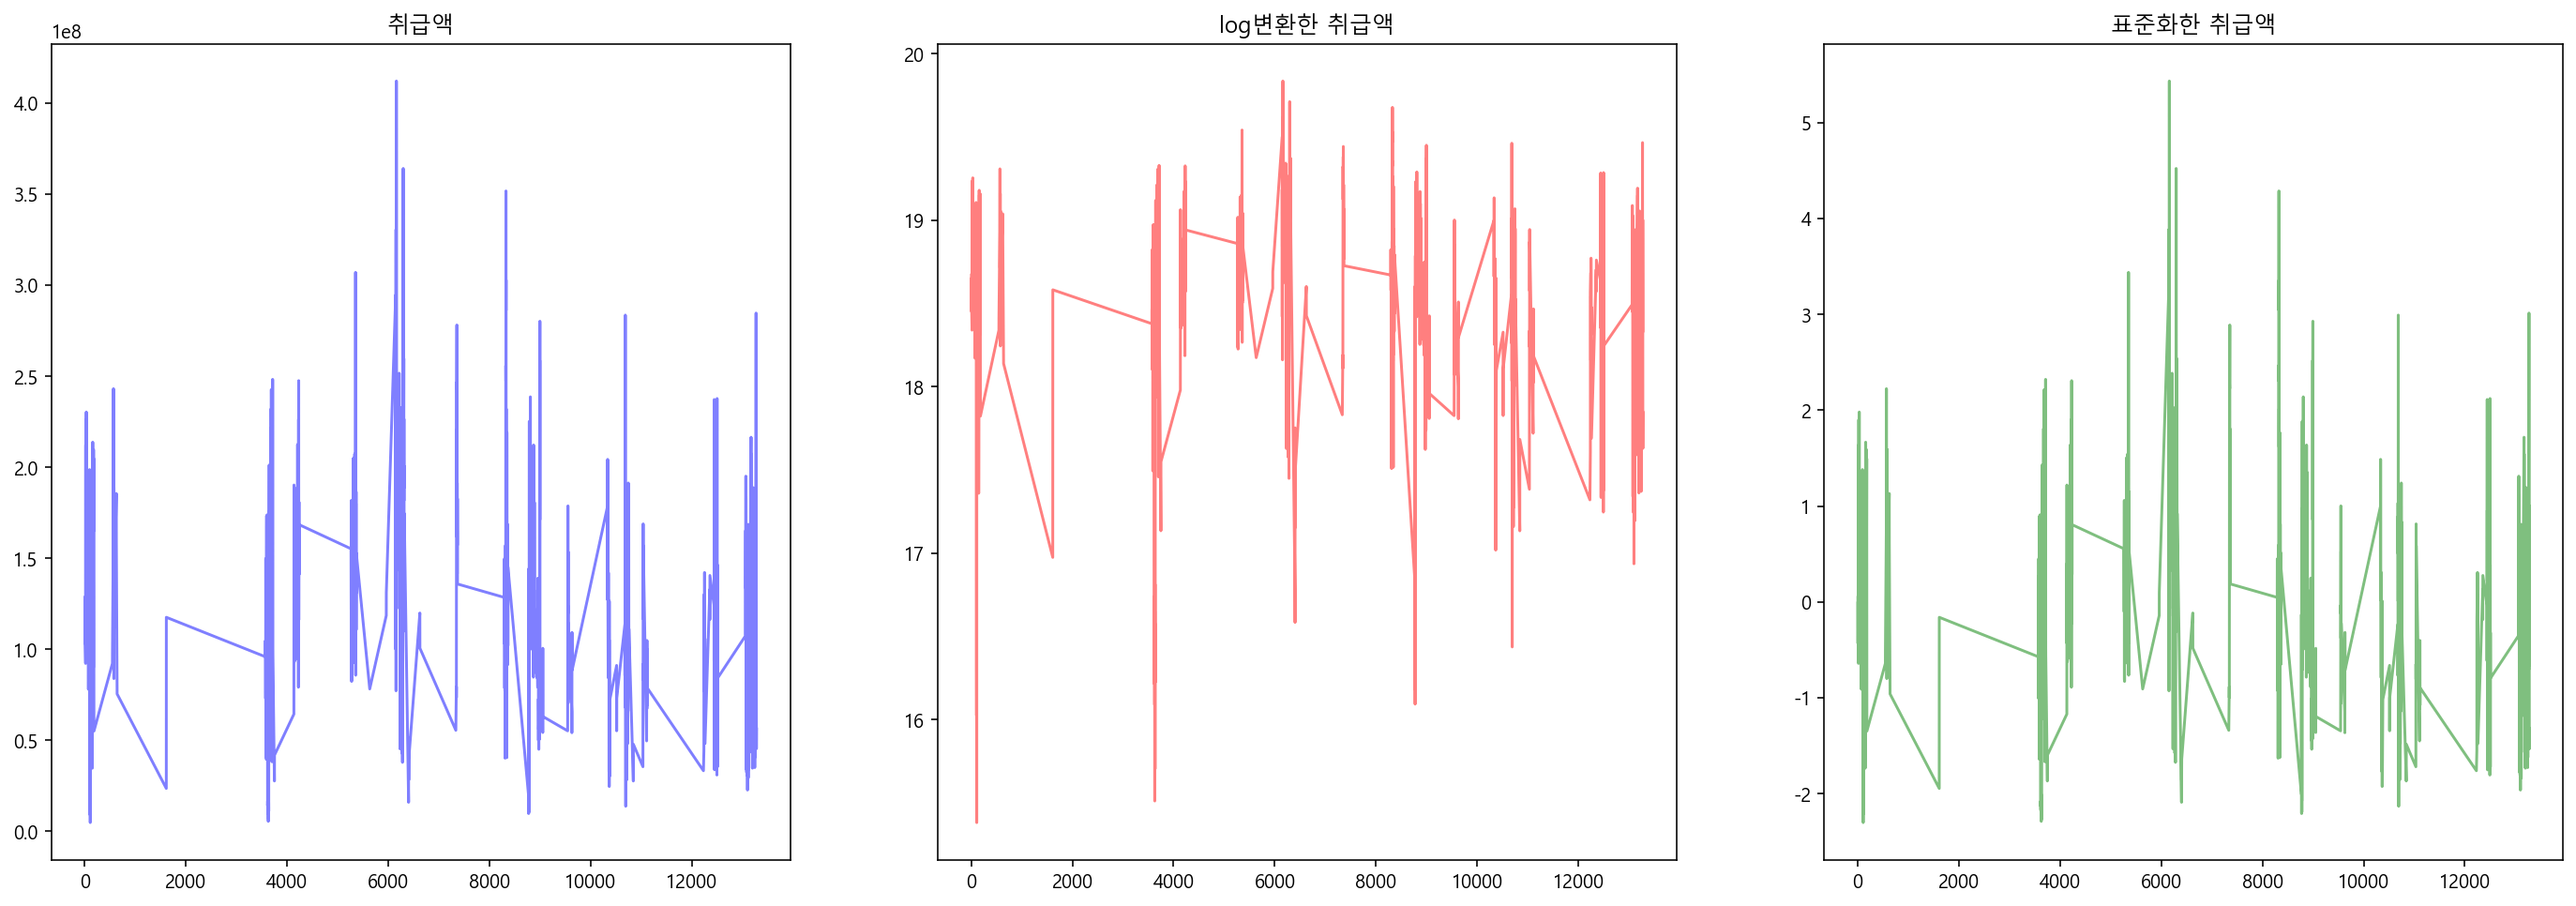


상품군: 생활용품
데이터 개수: 1011


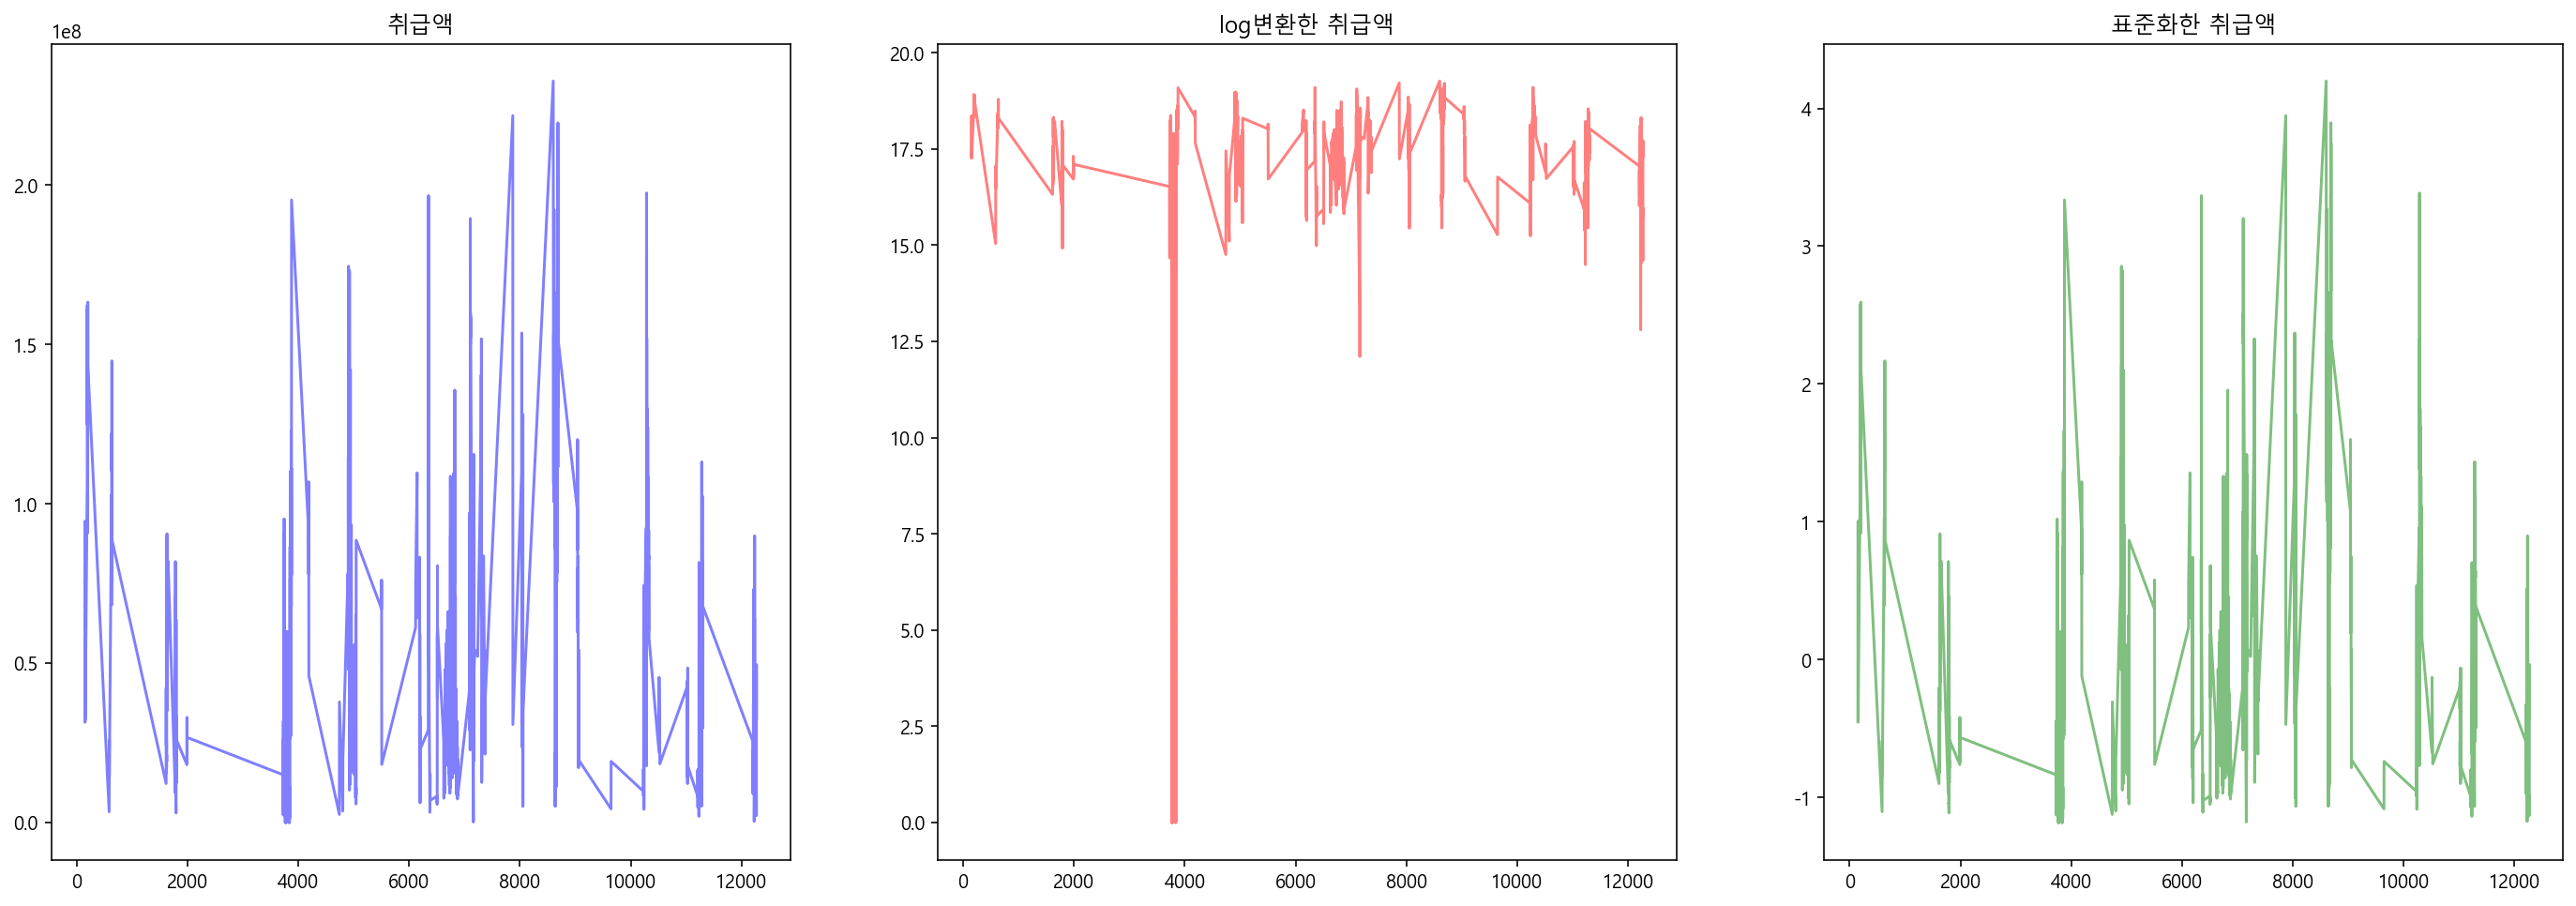


상품군: 속옷
데이터 개수: 1346


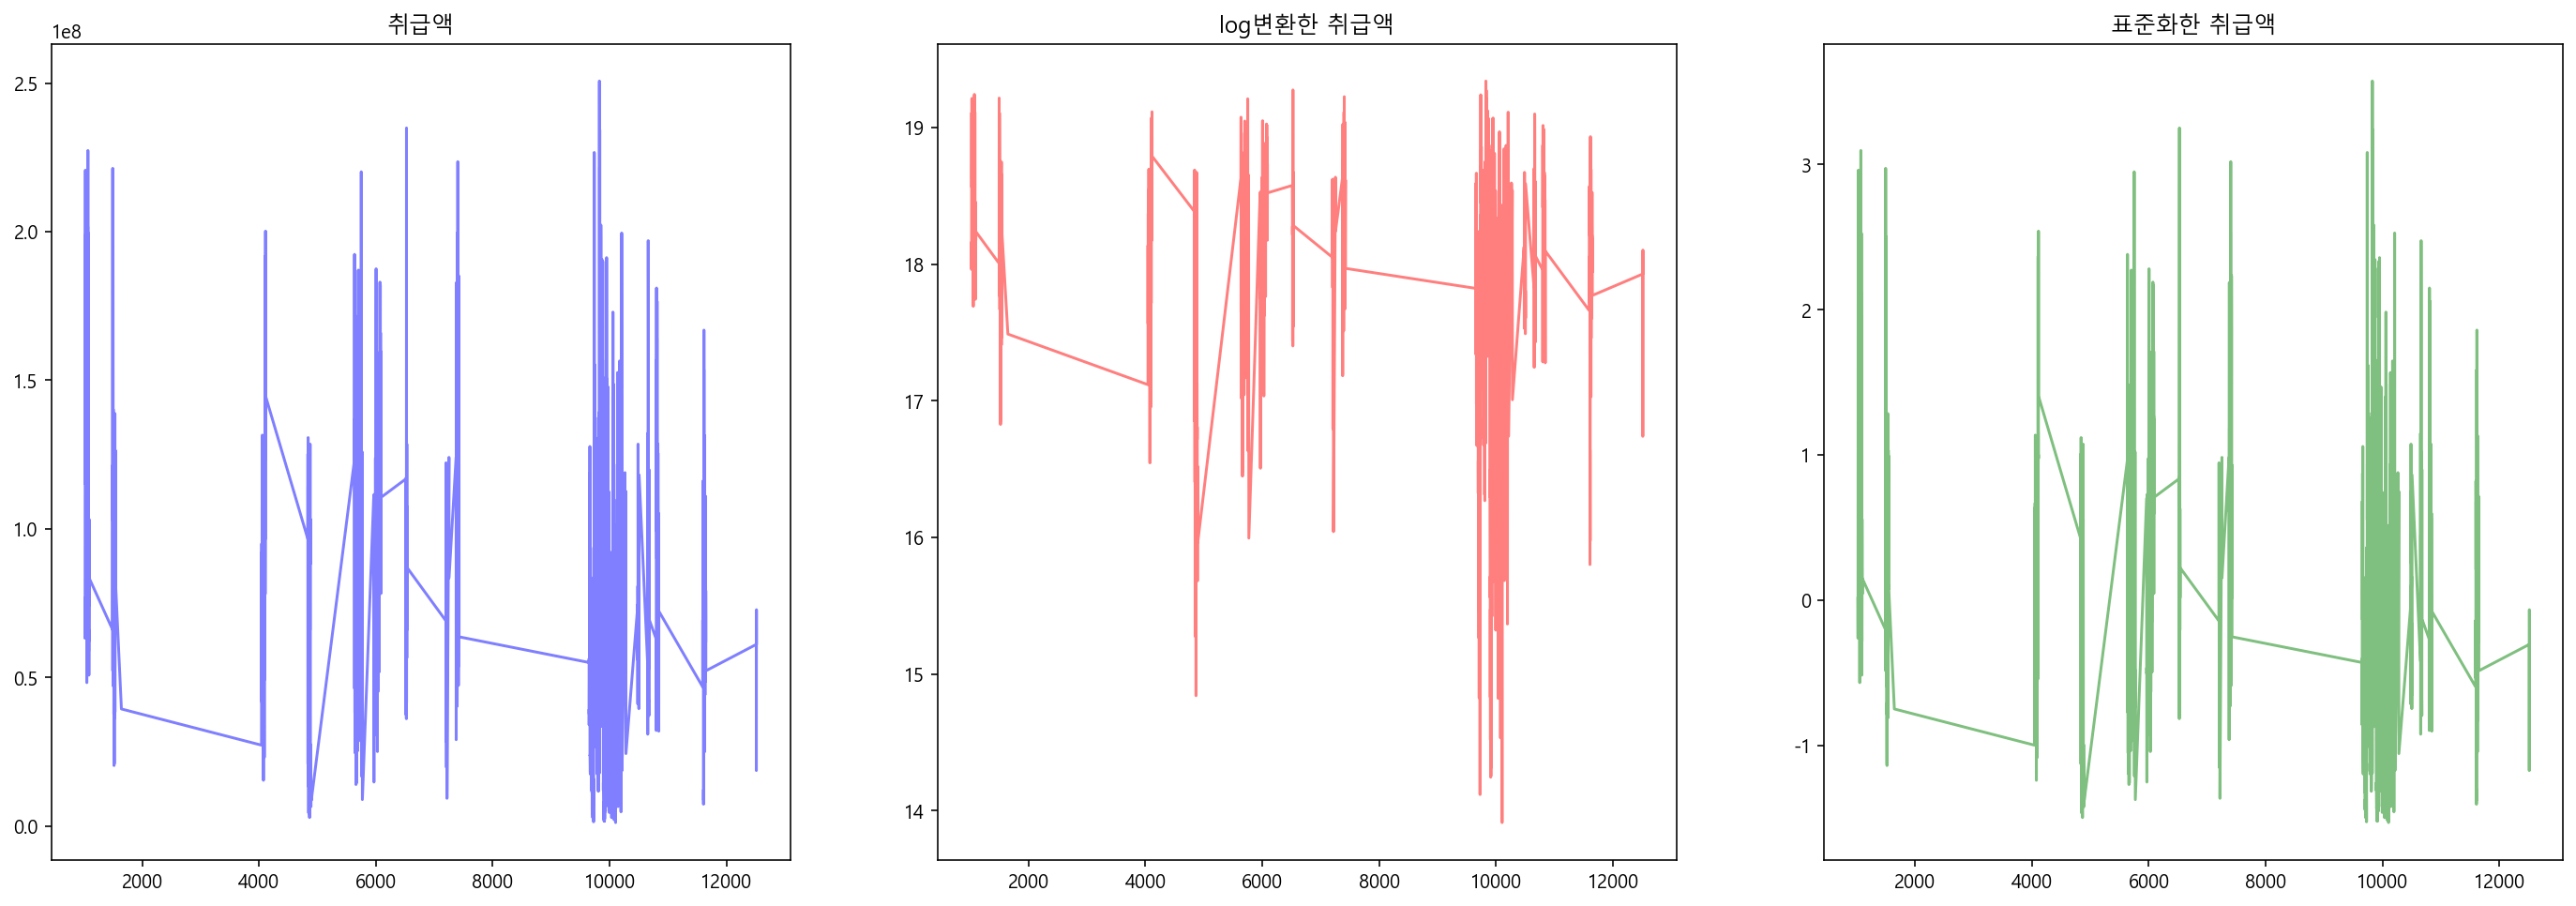


상품군: 의류
데이터 개수: 1458


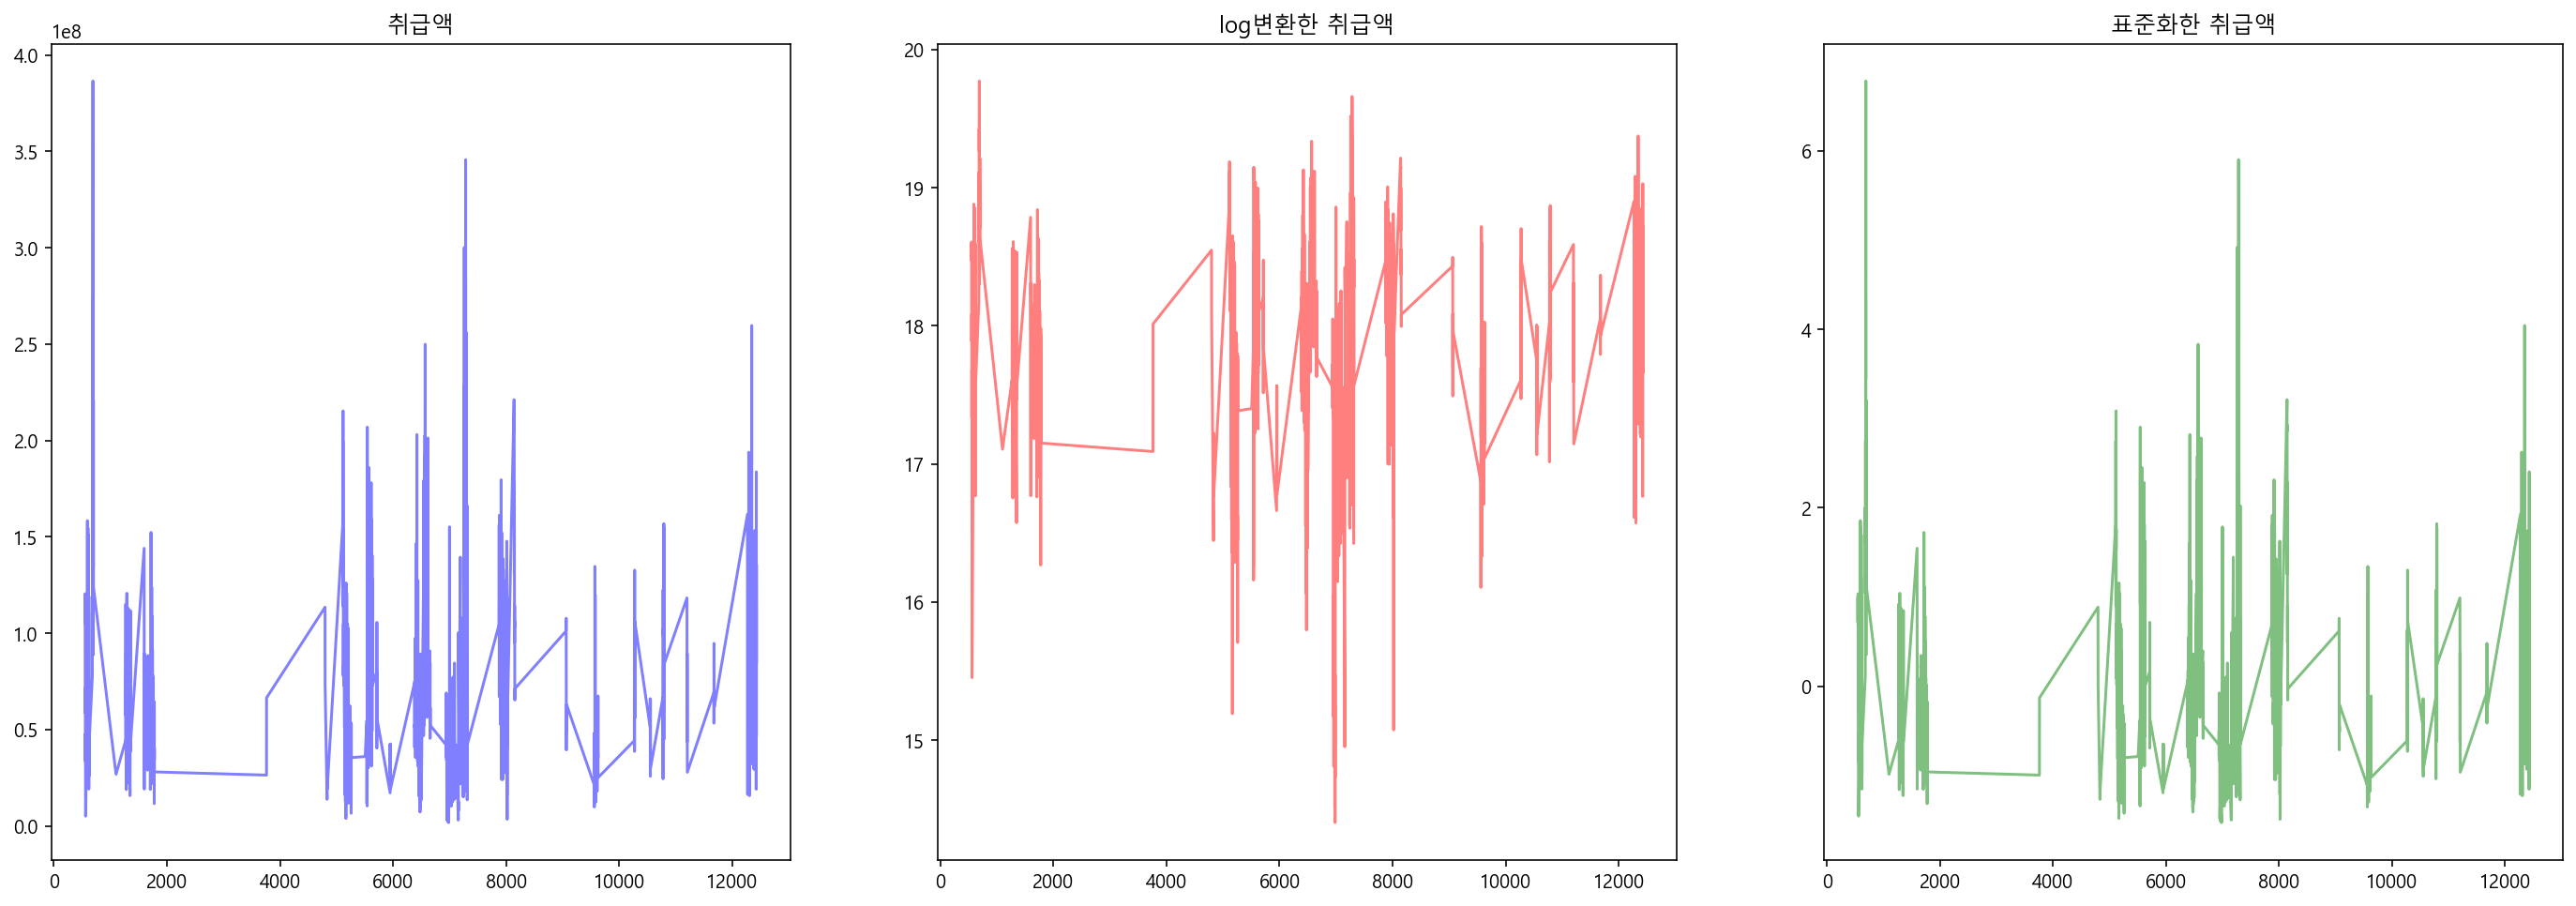


상품군: 이미용
데이터 개수: 454


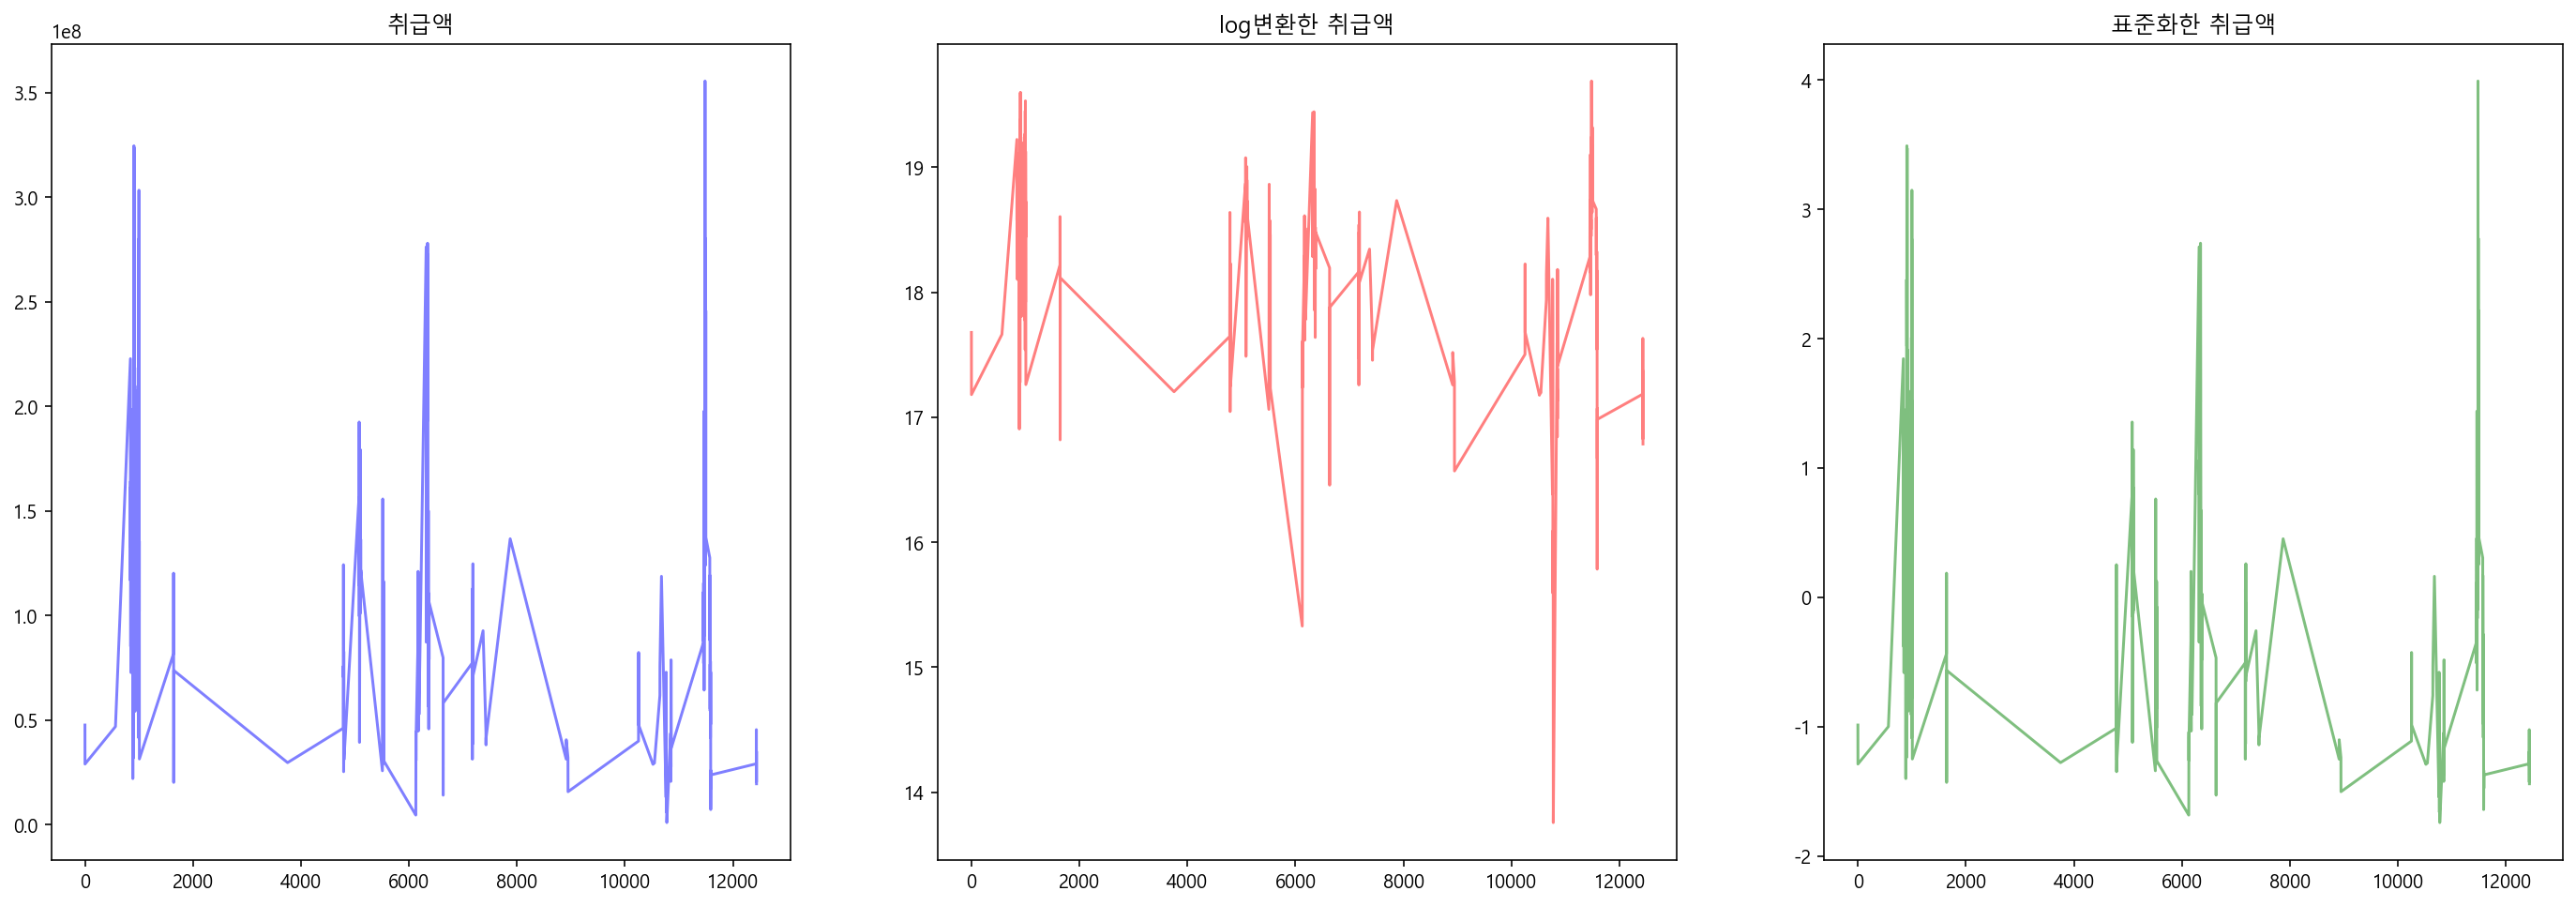


상품군: 잡화
데이터 개수: 1854


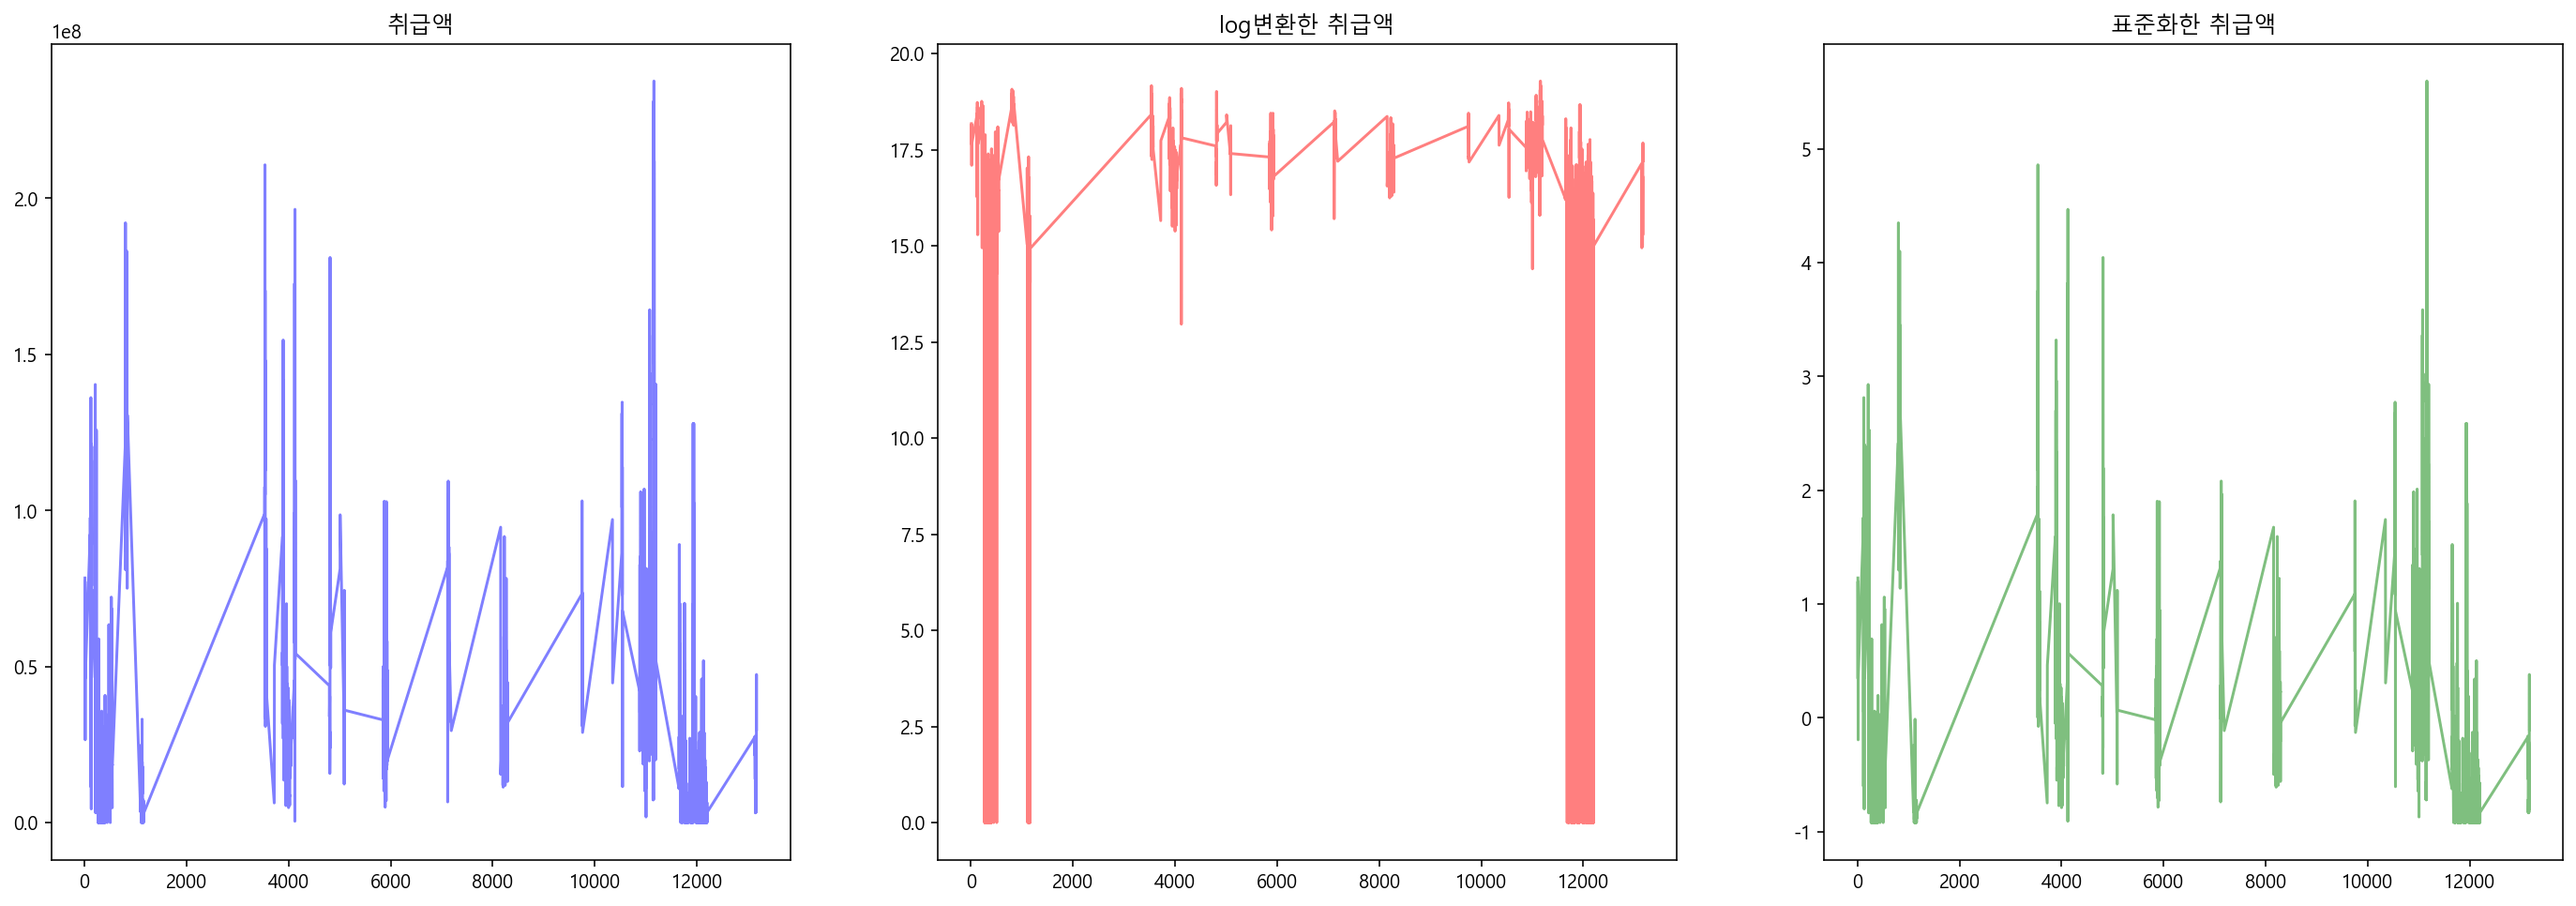


상품군: 주방
데이터 개수: 2272


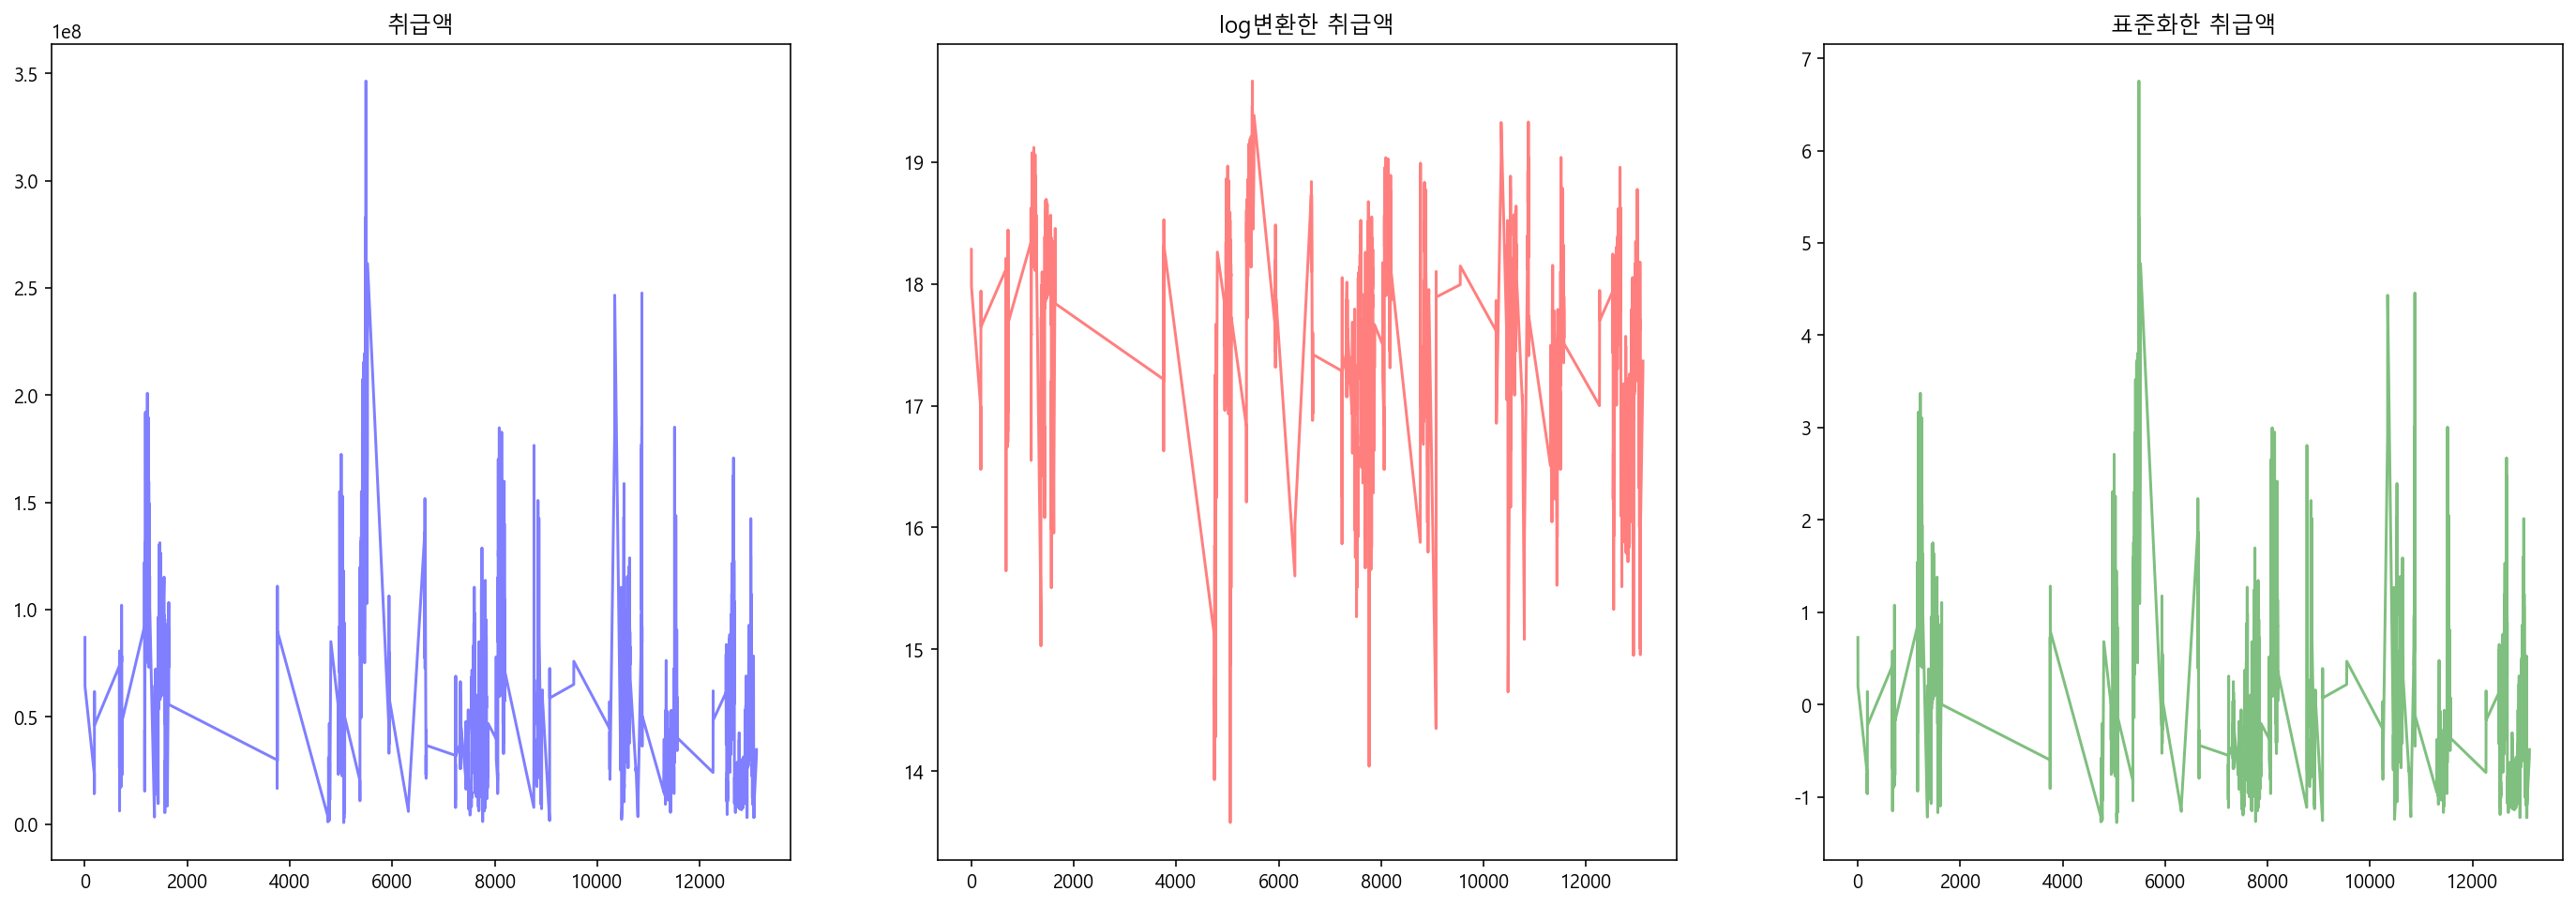


상품군: 침구
데이터 개수: 232


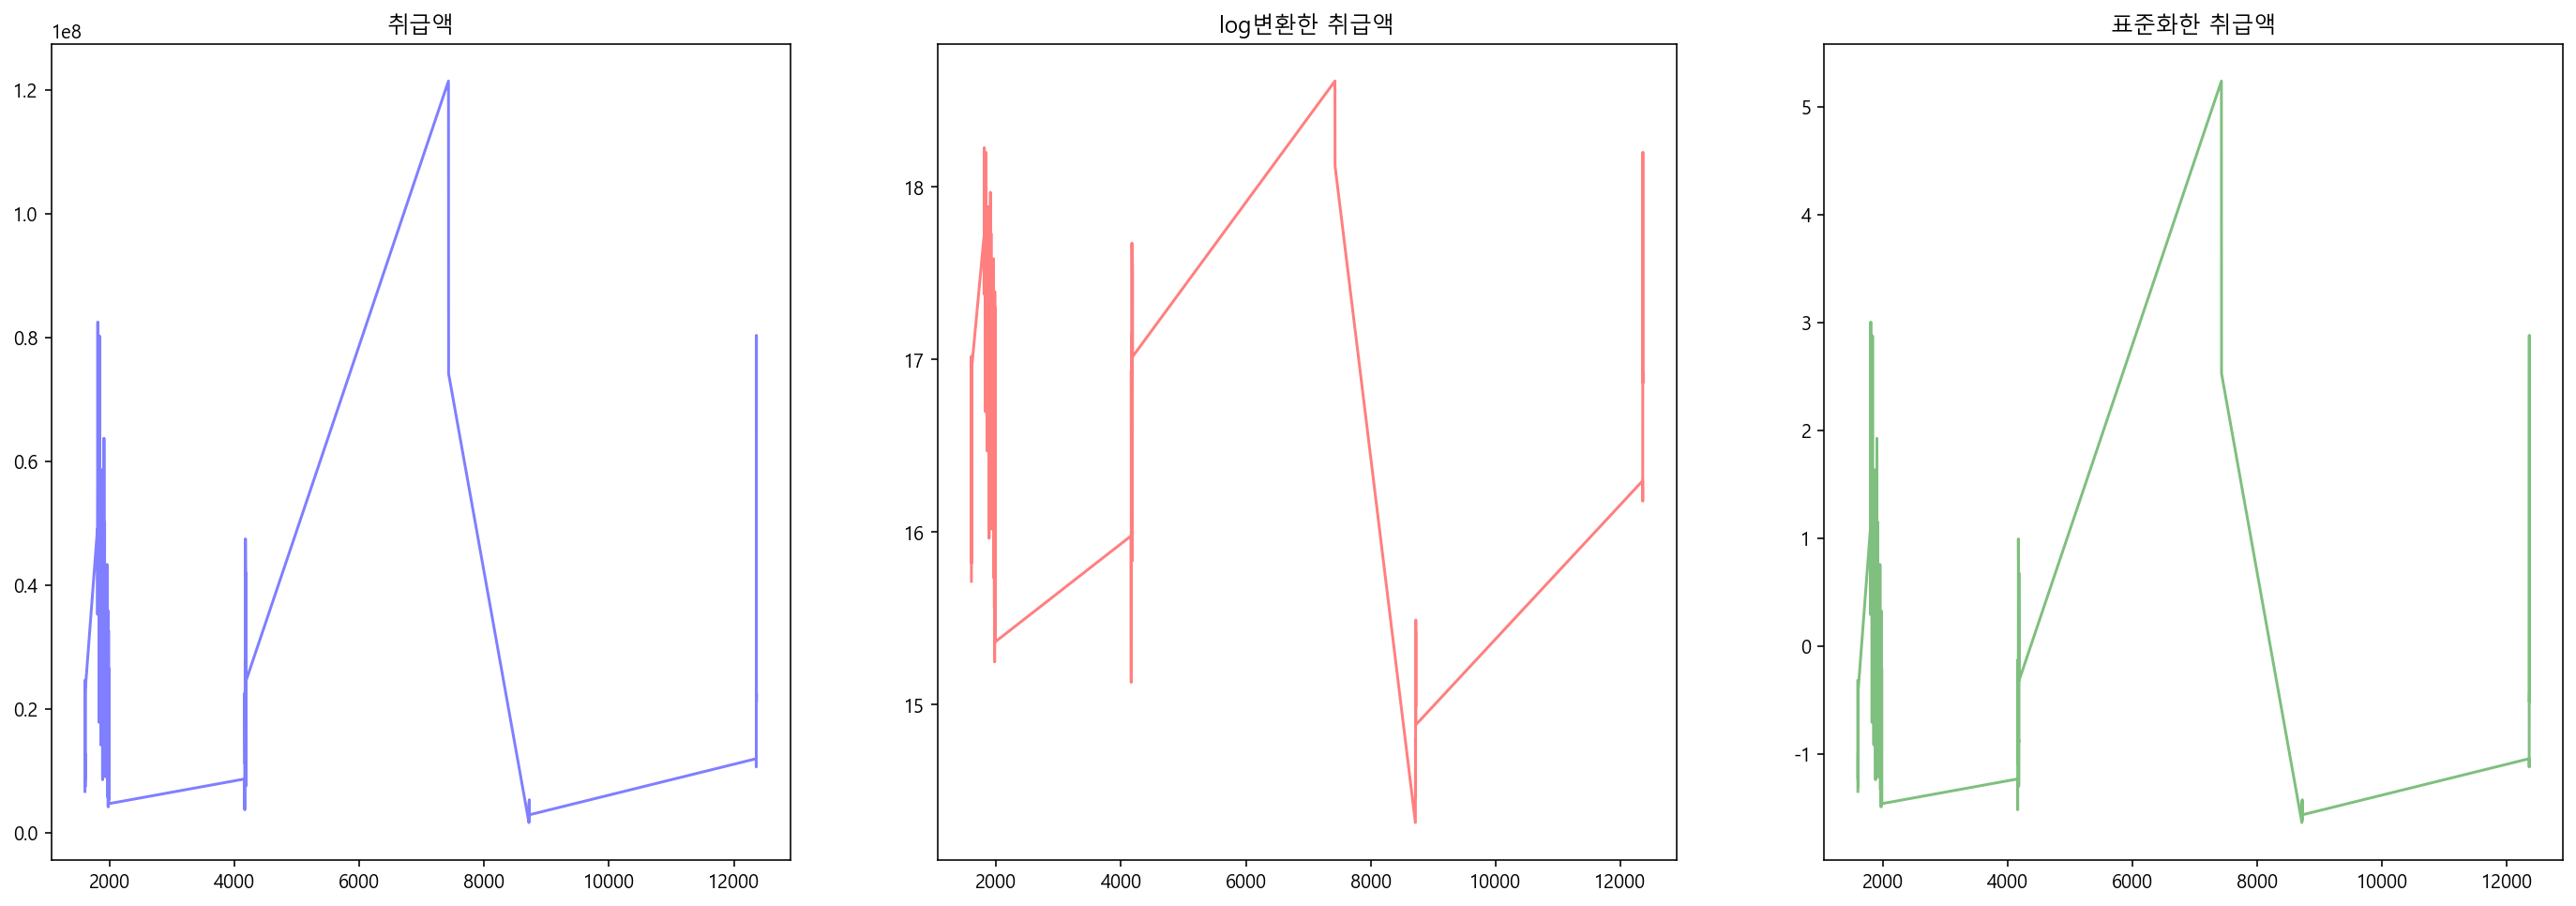

In [83]:
# 상품군별 취급액 추이
# 취급액 추이
dfs = dict(tuple(data.groupby(by='상품군')))
for k, v in dfs.items():
    
    scaler= StandardScaler()
    dfs[k]['취급액_표준화'] = scaler.fit_transform(dfs[k]['취급액'].values.reshape(-1, 1))
    
    fig = plt.figure(figsize=(24, 8))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    print(f"상품군: {k}\n데이터 개수: {len(dfs[k])}")  
    
    ax1.plot(dfs[k]['취급액'], color='blue', alpha=0.5)
    ax1.set_title('취급액')
    ax2.plot(np.log1p(dfs[k]['취급액']), color='red', alpha=0.5)
    ax2.set_title('log변환한 취급액')
    ax3.plot(dfs[k]['취급액_표준화'], color='green', alpha=0.5)
    ax3.set_title('표준화한 취급액')
    plt.show()
    print()